# EWMAC + Meta-Labelling

<div class="alert alert-block alert-info">
<b>Note:</b> The data used in this notebook is sourced from FirstRate Data. To run this notebook, the FirstRate Data, or equivalent data in the same format, is required. </div>

### 1. Imports

In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pyfolio as pf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
import csv

import os
os.environ['MLFINLAB_API_KEY'] = "e576e4abb9c98802834ca02f123ef4ba"
# Import MlFinLab tools
import mlfinlab as ml

import sys
sys.path.append(os.path.abspath('../pysystemtrade'))

from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from sysquant.estimators.vol import robust_vol_calc
from systems.accounts.account_forecast import pandl_for_instrument_forecast
%matplotlib inline

### 2. Reading and pre-processing data

In [ ]:
CRUDE_OIL = 'CL'
NAT_GAS = 'NG'
BRENT_CRUDE = 'BZ'
GAS = 'RB'
HEAT_OIL = 'HO'

fuel_futures = [CRUDE_OIL, NAT_GAS, BRENT_CRUDE, GAS, HEAT_OIL]

S_P_500 = 'ES'
NASDAQ = 'NQ'
EUROSTOXX = 'FX'
DAX = 'DY'
FT_100 = 'X'

equity_futures = [S_P_500, NASDAQ, EUROSTOXX, DAX, FT_100]

# Compute moving averages
SHORT_LB = 50
LONG_LB = 100

In [ ]:
# Define the data paths according to the structure of the project
FUEL_FUTURES_PATH = '../data/fuel_first_rate_data_R_prices.parquet'
EQUITY_FUTURES_PATH = '../data/equity_indices_first_rate_data_R_prices.parquet'

# This is where csv files must be placed for pysystemtrade to access them
CSV_PATH = '../pysystemtrade/data/firstrate_futures/meta-labelling'

In [ ]:
# Read in data
start_datetime = '2018-01-02'

fuel_futures_data = pd.read_parquet(FUEL_FUTURES_PATH)
equity_futures_data = pd.read_parquet(EQUITY_FUTURES_PATH)

In [ ]:
# Function to convert data in a futures data file into individual csv files
def convert_parquet_to_csv(src_dataframe: pd.DataFrame, dst_path: str, symbols: list) -> None:
    """_summary_

    Args:
        src_path (str): _description_
        dst_path (str): _description_
    """

    for i, column in enumerate(symbols):

        dst_filename = dst_path + f'/{symbols[i]}.csv'

        # Convert column into csv file
        src_dataframe[column].to_csv(dst_filename, header=["price"])

        # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
        in_csv_file = open(dst_filename, "r")
        csv_reader = csv.reader(in_csv_file)

        lines = list(csv_reader)
        lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

        # Separate file object exclusively for writing
        out_csv_file = open(dst_filename, "w")
        csv_writer = csv.writer(out_csv_file)
        csv_writer.writerows(lines)

        in_csv_file.close()
        out_csv_file.close()

In [ ]:
convert_parquet_to_csv(fuel_futures_data, CSV_PATH, fuel_futures)
convert_parquet_to_csv(equity_futures_data, CSV_PATH, equity_futures)

### 3. EWMAC+Meta-Labelling Backtesting

In [29]:
def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """

    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    forecast = raw_ewmac.where(raw_ewmac > 0, 1.0)
    forecast = forecast.where(raw_ewmac < 0, -1.0)
    return forecast

In [30]:
def compute_ewmas(data: pd.DataFrame, fast_window: int, slow_window: int) -> pd.DataFrame:
    '''
    '''
    data[FAST_EWMA] = data[CLOSE].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
    data[SLOW_EWMA] = data[CLOSE].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
    return data

def compute_primary_signals(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    '''
    # Initialize new column 'side'
    dataframe[SIDE] = np.nan
    
    long_signals = dataframe[FAST_EWMA] >= dataframe[SLOW_EWMA] 
    short_signals = dataframe[FAST_EWMA] < dataframe[SLOW_EWMA] 
    dataframe.loc[long_signals, SIDE] = 1
    dataframe.loc[short_signals, SIDE] = -1
    
    # Remove Look ahead bias by lagging the signal
    dataframe[SIDE] = dataframe[SIDE].shift(1)
    return dataframe

#### 3.1 EWMAC+Meta-Labelling on Fuel contracts

In [62]:
def run_ewmac_meta_labelling_fuels():

    futures_data = pd.read_parquet('../data/fuel_first_rate_data_R_prices.parquet')

    accounts = []
    feat_imps = []
    primary_accounts = []

    for i in range(len(fuel_futures)):
        print("--------------------------------------------")
        print(f"COLUMN: {fuel_futures[i]}") 

        csv_path = f"../../pysystemtrade/data/firstrate_futures/{fuel_futures[i]}.csv"
        futures_data[fuel_futures[i]].to_csv(csv_path, header=["price"])

        # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
        in_csv_file = open(csv_path, "r")
        csv_reader = csv.reader(in_csv_file)

        lines = list(csv_reader)
        lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

        out_csv_file = open(csv_path, "w")
        csv_writer = csv.writer(out_csv_file)
        csv_writer.writerows(lines)

        in_csv_file.close()
        out_csv_file.close()

        # Compute moving averages
        fast_window = 50
        slow_window = 100

        instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))
        data = pd.DataFrame()
        price = instrument_data.get_raw_price(fuel_futures[i])
        print(price)
        data[CLOSE] = price
        data[SIDE] = calc_ewmac_forecast(price, fast_window, slow_window)
        data.columns = [CLOSE, 'forecast']

        print(data)

        account = pandl_for_instrument_forecast(forecast=data['forecast'], price=data[CLOSE])
        plt.figure(figsize=(20,5))
        plt.plot(account.curve())
        plt.show()

        data.columns = [CLOSE, SIDE]

        # Save the raw data
        raw_data = data.copy()

        # Drop the NaN values from our data set
        data.dropna(axis=0, how='any', inplace=True)

        # Compute daily volatility
        daily_vol = ml.util.get_daily_vol(close=data[CLOSE], lookback=50)

        # Apply Symmetric CUSUM Filter and get timestamps for events
        # Note: Only the CUSUM filter needs a point estimate for volatility
        cusum_events = ml.filters.cusum_filter(data[CLOSE], threshold=daily_vol['2012-09-30':'2018-01-01'].mean()*0.5)

        # Compute vertical barrier
        vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data[CLOSE], num_days=1)

        pt_sl = [1,2]
        min_ret = 0.005
        triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                                   t_events=cusum_events,
                                                   pt_sl=pt_sl,
                                                   target=daily_vol,
                                                   min_ret=min_ret,
                                                   num_threads=3,
                                                   vertical_barrier_times=vertical_barriers,
                                                   side_prediction=data['side'])

        labels = ml.labeling.get_bins(triple_barrier_events, data[CLOSE])
        labels.side.value_counts()

        primary_forecast = pd.DataFrame(labels[BIN])
        primary_forecast[PRED] = 1
        primary_forecast.columns = [ACTUAL, PRED]

        # Performance Metrics
        actual = primary_forecast[ACTUAL]
        pred = primary_forecast[PRED]
        print(classification_report(y_true=actual, y_pred=pred))

        primary_cm = confusion_matrix(actual, pred)
        print(primary_cm)

    #     disp = ConfusionMatrixDisplay(confusion_matrix=primary_cm,
    #                                display_labels=[0, 1])
    #     disp.plot(cmap='Blues')
    #     plt.savefig(f"../output_figs/primary_forecast_cm_{fuel_futures[i]}")
    #     plt.show()

        # Log Returns
        raw_data['log_ret'] = np.log(raw_data[CLOSE]).diff()

        # Momentum
        raw_data['mom10'] = raw_data[CLOSE].pct_change(periods=10)
        raw_data['mom50'] = raw_data[CLOSE].pct_change(periods=50)
        raw_data['mom100'] = raw_data[CLOSE].pct_change(periods=100)
        raw_data['mom200'] = raw_data[CLOSE].pct_change(periods=200)
        raw_data['mom500'] = raw_data[CLOSE].pct_change(periods=500)

        # Volatility
        raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
        raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
        raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

        # Serial Correlation (Takes about 4 minutes)
        window_autocorr = 50

        raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
        raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
        raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
        raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
        raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

        # Get the various log -t returns
        raw_data['log_t1'] = raw_data['log_ret'].shift(1)
        raw_data['log_t2'] = raw_data['log_ret'].shift(2)
        raw_data['log_t3'] = raw_data['log_ret'].shift(3)
        raw_data['log_t4'] = raw_data['log_ret'].shift(4)
        raw_data['log_t5'] = raw_data['log_ret'].shift(5)

        # Re compute sides
        raw_data['side'] = np.nan

    #     long_signals = raw_data[FAST_EWMA] >= raw_data[SLOW_EWMA]
    #     short_signals = raw_data[FAST_EWMA] < raw_data[SLOW_EWMA]

    #     raw_data.loc[long_signals, 'side'] = 1
    #     raw_data.loc[short_signals, 'side'] = -1

    #     raw_data = raw_data.shift(1)

        raw_data[SIDE] = calc_ewmac_forecast(price, fast_window, slow_window)

        X = raw_data.loc[labels.index, :]

    # Drop unwanted columns
        X.drop([CLOSE],
               axis=1, inplace=True)

        y = labels[BIN]

        # Split data into training, validation and test sets
        X_training_validation = X['2011-09-01':'2018-01-01']
        y_training_validation = y['2011-09-01':'2018-01-01']
        X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation,
                                                                    test_size=0.15, shuffle=False)
        train_df = pd.concat([y_train, X_train], axis=1, join='inner')

        majority = train_df[train_df[BIN] == 0]
        minority = train_df[train_df[BIN] == 1]

        new_minority = resample(minority, 
                           replace=True,  # Sample with replacement
                           n_samples=majority.shape[0],  # To match majority class
                           random_state=42)

        train_df = pd.concat([majority, new_minority])
        train_df = shuffle(train_df, random_state=42)

        train_df[BIN].value_counts()


        y_train = train_df[BIN]
        X_train= train_df.loc[:, train_df.columns != BIN]

        X_train = X_train.fillna(0.0)

        parameters = {'max_depth':[2, 3, 4, 5, 7],
                      'n_estimators':[1, 10, 25, 50, 100],
                      'random_state':[42]}

    #     n_estimator = 25
    #     depth = 5

        n_estimator, depth = perform_grid_search(X_train, y_train)
        c_random_state = 42

        print(n_estimator, depth, c_random_state)

        # Refit a new model with best params, so we can see feature importance
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                                    criterion='entropy', random_state=c_random_state)

        rf.fit(X_train, y_train.values.ravel())

        # Performance Metrics
        y_pred_rf = rf.predict_proba(X_train)[:, 1]
        y_pred = rf.predict(X_train)
        fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
        print(classification_report(y_train, y_pred))

        print("Confusion Matrix")
        cm = confusion_matrix(y_train, y_pred)
        print(cm)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    #                                display_labels=[0, 1])
    #     disp.plot(cmap='Blues')
    #     plt.savefig(f"../output_figs/meta_model_train_cm_{fuel_futures[i]}")
    #     plt.show()


        print('')
        print("Accuracy")
        print(accuracy_score(y_train, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (Random Forest Meta Model - Training)')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        # Meta-label
        # Performance Metrics
        y_pred_rf = rf.predict_proba(X_validate)[:, 1]
        y_pred = rf.predict(X_validate)
        fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
        print(classification_report(y_validate, y_pred))

        print("Confusion Matrix")
        print(confusion_matrix(y_validate, y_pred))

        print('')
        print("Accuracy")
        print(accuracy_score(y_validate, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (Random Forest Meta Model - Validation)')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        # Primary model
        primary_forecast = pd.DataFrame(labels['bin'])
        primary_forecast['pred'] = 1
        primary_forecast.columns = ['actual', 'pred']

        start = primary_forecast.index.get_loc(f'{X_validate.index.min()}')
        end = primary_forecast.index.get_loc(f'{X_validate.index.max()}') + 1

        subset_prim = primary_forecast[start:end]

        # Performance Metrics
        actual = subset_prim['actual']
        pred = subset_prim['pred']
        print(classification_report(y_true=actual, y_pred=pred))

        print("Confusion Matrix")
        print(confusion_matrix(actual, pred))

        print('')
        print("Accuracy")
        print(accuracy_score(actual, pred))

        # Feature Importance

        feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
        feat_imp['feature'] = X.columns
        feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
        feat_imp = feat_imp

        feat_imp.sort_values(by='Importance', inplace=True)
        feat_imp = feat_imp.set_index('feature', drop=True)

        feat_imps.append(feat_imp)
    #     plt.xlabel('Feature Importance Score')
    #     plt.show()

        valid_dates = X_validate.index
        base_rets = labels.loc[valid_dates, 'ret']
        primary_model_rets = get_daily_returns(base_rets)

        meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
        daily_meta_rets = get_daily_returns(meta_returns)

        X_oos = X['2018-01-02':]
        y_oos = y['2018-01-02':]

        y_pred_rf = rf.predict_proba(X_oos)[:, 1]
        y_pred = rf.predict(X_oos)
        fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
        print(classification_report(y_oos, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (RF - Out Of Sample)')
        plt.legend(loc='best')
        plt.show()

        # Primary model
        primary_forecast = pd.DataFrame(labels['bin'])
        primary_forecast['pred'] = 1
        primary_forecast.columns = ['actual', 'pred']

        subset_prim = primary_forecast['2018-01-02':]

        # Performance Metrics
        actual = subset_prim['actual']
        pred = subset_prim['pred']
        print(classification_report(y_true=actual, y_pred=pred))

        print("Confusion Matrix")
        print(confusion_matrix(actual, pred))

        print('')
        print("Accuracy")
        print(accuracy_score(actual, pred))

        test_dates = X_oos.index

        meta_returns = labels.loc[test_dates, 'ret'] * y_pred
        daily_rets_meta = get_daily_returns(meta_returns)

        idx = pd.date_range('2018-01-03 10:00:00', '2021-10-01 10:00:00', freq='H')
        labels = labels.reindex(idx, fill_value=0.0)

        meta_label_forecast = pd.Series(labels['trgt'])
        meta_label_forecast.columns = ['forecast']

        # Convert csv data into data object for pysystemtrade
        instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

            # Get daily prices and calculate the ewmac forecast
        price = instrument_data.get_raw_price(futures_data.columns[i])
        price_oos = price['2018-01-03 10:00:00':]
        meta_label_forecast.reindex(price_oos.index)

        primary = pd.Series(primary_forecast['actual'])
        primary.reindex(price_oos.index)

        account = pandl_for_instrument_forecast(forecast=meta_label_forecast, price=price_oos)
        accounts.append(account)

        primary_account = pandl_for_instrument_forecast(forecast=primary, price=price_oos)
        primary_accounts.append(primary_account)
    return primary_accounts, accounts, feat_imps

--------------------------------------------
COLUMN: CL
2023-06-14 11:41:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:41:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:41:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:41:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:41:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
index
2012-09-10 14:00:00    126.74
2012-09-10 15

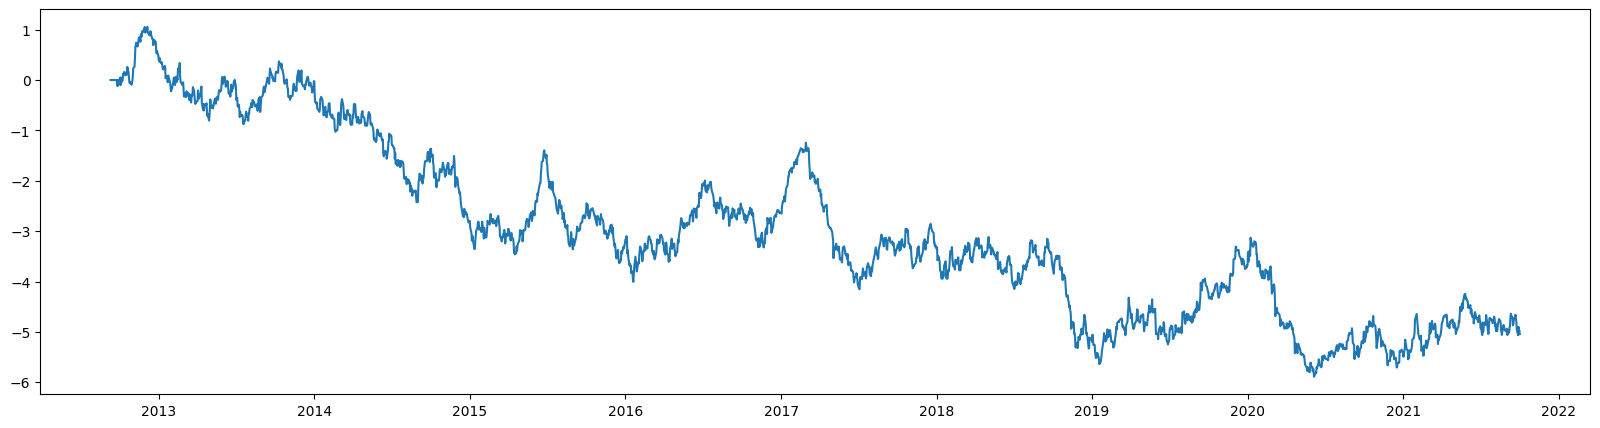

(CVXPY) Jun 14 11:41:52 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:41:56.219952 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7497
           1       0.31      1.00      0.47      3370

    accuracy                           0.31     10867
   macro avg       0.16      0.50      0.24     10867
weighted avg       0.10      0.31      0.15     10867

[[   0 7497]
 [   0 3370]]
[0.5156681  0.58056658 0.60519397 0.60835529 0.61247446 0.53189632
 0.61068851 0.63037326 0.64107997 0.6470691  0.5574849  0.64231145
 0.66756962 0.67462888 0.6804469  0.56911605 0.66844731 0.69951398
 0.71255699 0.71642333 0.59555406 0.73012769 0.77524121 0.79144862
 0.79598196]
100 7 42
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2790
           1       0.83      0.74      0.78      2790

    accuracy                           0.79      5580
   macro avg       0.80      0.79      0.79      5580
weighted avg       0.80      0.79      0.79      5580

Confusion Matrix
[[2355  435]

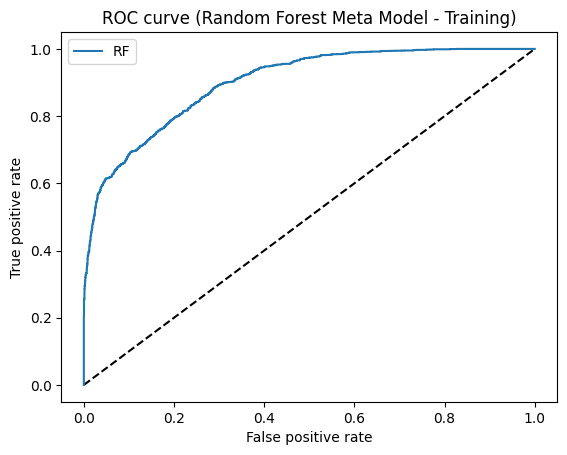

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       505
           1       0.32      0.40      0.36       217

    accuracy                           0.57       722
   macro avg       0.52      0.52      0.52       722
weighted avg       0.60      0.57      0.58       722

Confusion Matrix
[[322 183]
 [130  87]]

Accuracy
0.5664819944598338


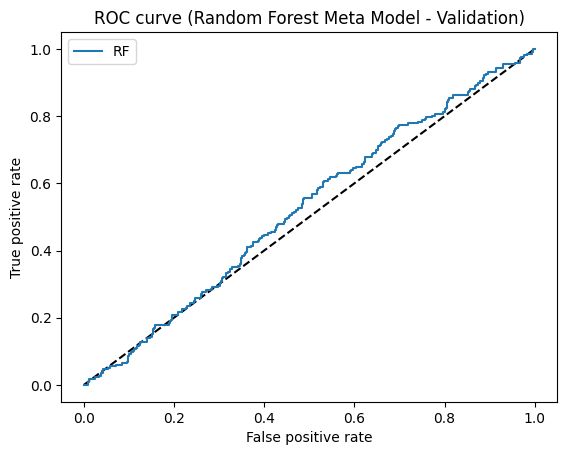

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       505
           1       0.30      1.00      0.46       217

    accuracy                           0.30       722
   macro avg       0.15      0.50      0.23       722
weighted avg       0.09      0.30      0.14       722

Confusion Matrix
[[  0 505]
 [  0 217]]

Accuracy
0.30055401662049863
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      4202
           1       0.32      0.45      0.37      1852

    accuracy                           0.54      6054
   macro avg       0.51      0.51      0.50      6054
weighted avg       0.59      0.54      0.55      6054



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

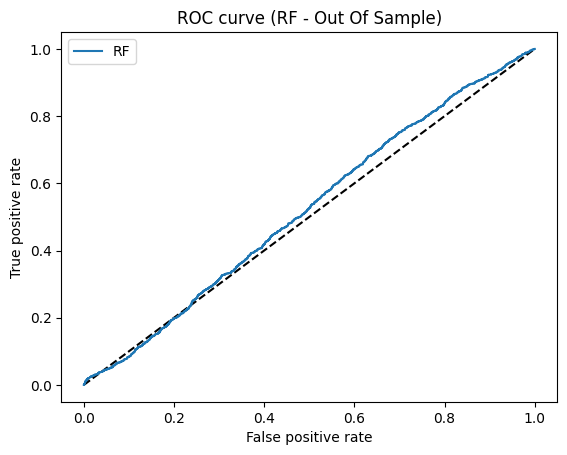

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4202
           1       0.31      1.00      0.47      1852

    accuracy                           0.31      6054
   macro avg       0.15      0.50      0.23      6054
weighted avg       0.09      0.31      0.14      6054

Confusion Matrix
[[   0 4202]
 [   0 1852]]

Accuracy
0.3059134456557648
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning]

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

--------------------------------------------
COLUMN: NG
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:42:30 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
index
2012-09-10 14:00:00    7.283
2012-09-10 15:

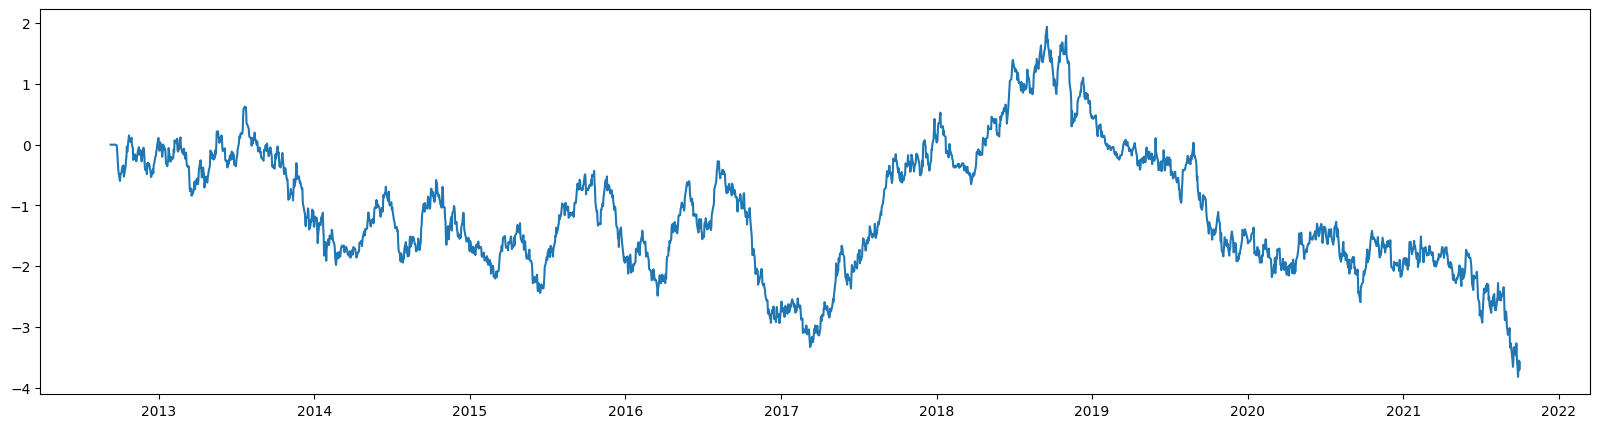

(CVXPY) Jun 14 11:42:32 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:42:35.828343 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6857
           1       0.31      1.00      0.47      3050

    accuracy                           0.31      9907
   macro avg       0.15      0.50      0.24      9907
weighted avg       0.09      0.31      0.14      9907

[[   0 6857]
 [   0 3050]]
[0.51991898 0.57537639 0.59600217 0.60423959 0.60816862 0.5216971
 0.59952475 0.62591502 0.635754   0.64385793 0.5457984  0.63642942
 0.66176006 0.67578649 0.68594664 0.55000953 0.671706   0.70501992
 0.72116247 0.73076642 0.57156173 0.71940774 0.77024643 0.79418714
 0.8126409 ]
100 7 42
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      2648
           1       0.76      0.91      0.83      2648

    accuracy                           0.81      5296
   macro avg       0.82      0.81      0.81      5296
weighted avg       0.82      0.81      0.81      5296

Confusion Matrix
[[1877  771]


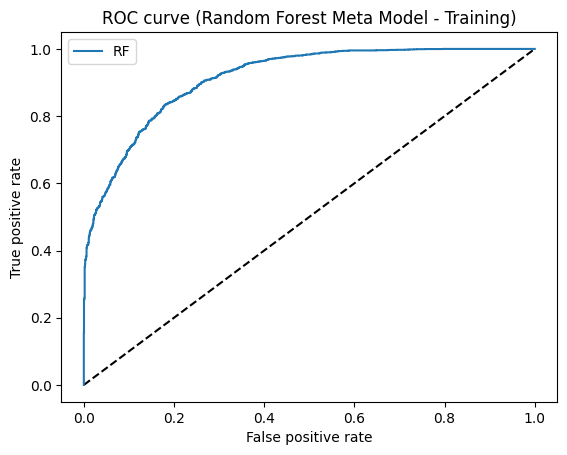

              precision    recall  f1-score   support

           0       0.71      0.59      0.64       445
           1       0.38      0.51      0.43       220

    accuracy                           0.56       665
   macro avg       0.54      0.55      0.54       665
weighted avg       0.60      0.56      0.57       665

Confusion Matrix
[[261 184]
 [108 112]]

Accuracy
0.5609022556390978


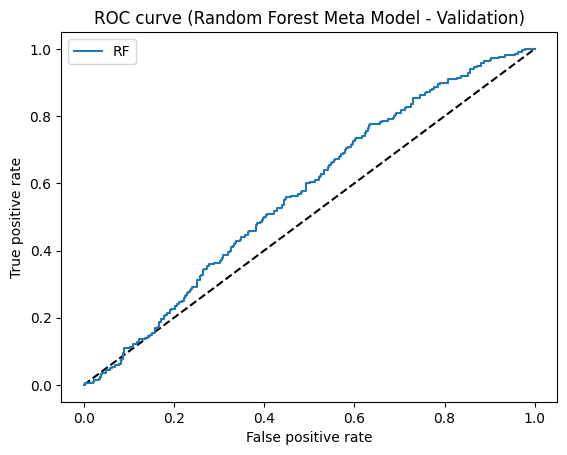

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       445
           1       0.33      1.00      0.50       220

    accuracy                           0.33       665
   macro avg       0.17      0.50      0.25       665
weighted avg       0.11      0.33      0.16       665

Confusion Matrix
[[  0 445]
 [  0 220]]

Accuracy
0.3308270676691729
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      3764
           1       0.34      0.25      0.28      1713

    accuracy                           0.61      5477
   macro avg       0.51      0.51      0.51      5477
weighted avg       0.58      0.61      0.59      5477



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

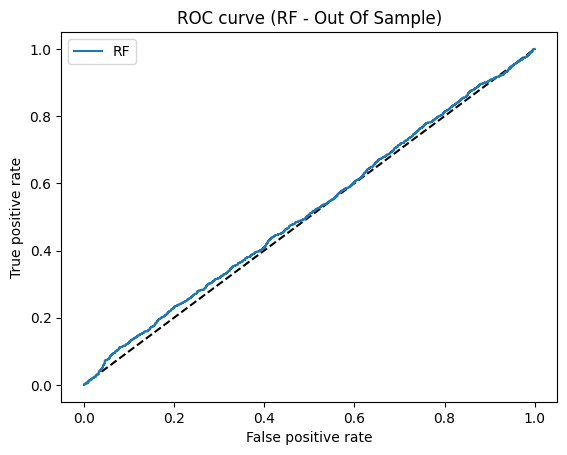

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3764
           1       0.31      1.00      0.48      1713

    accuracy                           0.31      5477
   macro avg       0.16      0.50      0.24      5477
weighted avg       0.10      0.31      0.15      5477

Confusion Matrix
[[   0 3764]
 [   0 1713]]

Accuracy
0.3127624612013876
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning]

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

--------------------------------------------
COLUMN: BZ
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:08 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
index
2012-09-10 14:00:00    113.14
2012-09-10 15

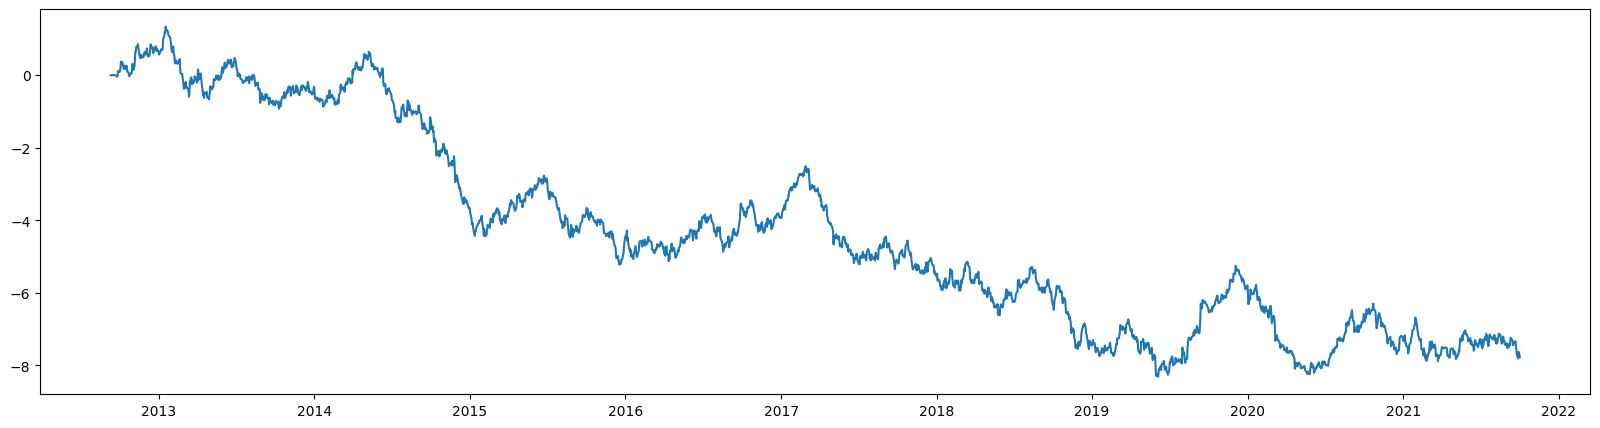

(CVXPY) Jun 14 11:43:10 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:43:13.368825 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7150
           1       0.32      1.00      0.48      3296

    accuracy                           0.32     10446
   macro avg       0.16      0.50      0.24     10446
weighted avg       0.10      0.32      0.15     10446

[[   0 7150]
 [   0 3296]]
[0.51434089 0.58109785 0.60051174 0.60998998 0.61669104 0.52913905
 0.62107059 0.640782   0.64601975 0.65147294 0.54829548 0.64055103
 0.67221856 0.68355106 0.68610908 0.56113008 0.68020481 0.70226058
 0.71595904 0.72213758 0.59641439 0.74247738 0.76742708 0.78844383
 0.79876906]
100 7 42
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2995
           1       0.82      0.82      0.82      2995

    accuracy                           0.82      5990
   macro avg       0.82      0.82      0.82      5990
weighted avg       0.82      0.82      0.82      5990

Confusion Matrix
[[2470  525]

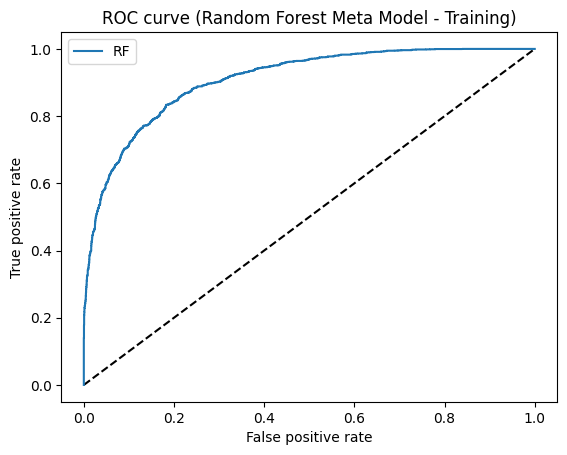

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       540
           1       0.35      0.44      0.39       239

    accuracy                           0.58       779
   macro avg       0.54      0.54      0.54       779
weighted avg       0.61      0.58      0.59       779

Confusion Matrix
[[349 191]
 [134 105]]

Accuracy
0.582798459563543


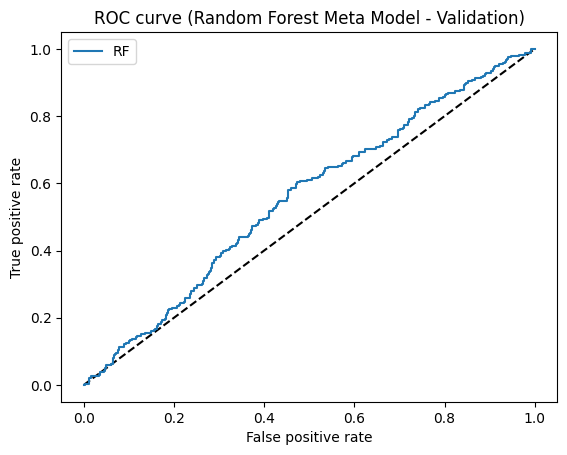

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       540
           1       0.31      1.00      0.47       239

    accuracy                           0.31       779
   macro avg       0.15      0.50      0.23       779
weighted avg       0.09      0.31      0.14       779

Confusion Matrix
[[  0 540]
 [  0 239]]

Accuracy
0.306803594351733
              precision    recall  f1-score   support

           0       0.70      0.58      0.64      3615
           1       0.33      0.45      0.38      1641

    accuracy                           0.54      5256
   macro avg       0.51      0.51      0.51      5256
weighted avg       0.58      0.54      0.56      5256



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

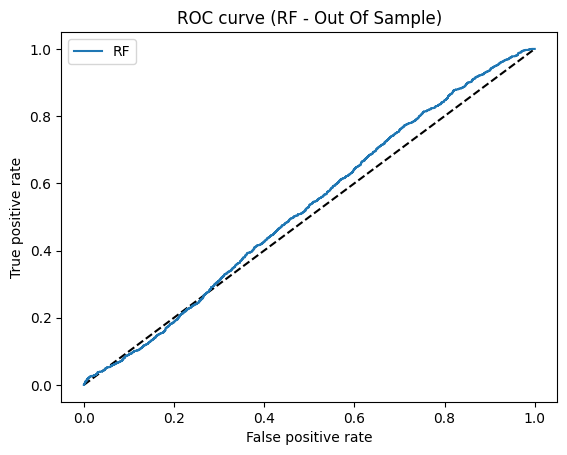

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3615
           1       0.31      1.00      0.48      1641

    accuracy                           0.31      5256
   macro avg       0.16      0.50      0.24      5256
weighted avg       0.10      0.31      0.15      5256

Confusion Matrix
[[   0 3615]
 [   0 1641]]

Accuracy
0.3122146118721461
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning]

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

--------------------------------------------
COLUMN: RB
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:43:46 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
index
2012-09-10 14:00:00    2.2324
2012-09-10 15

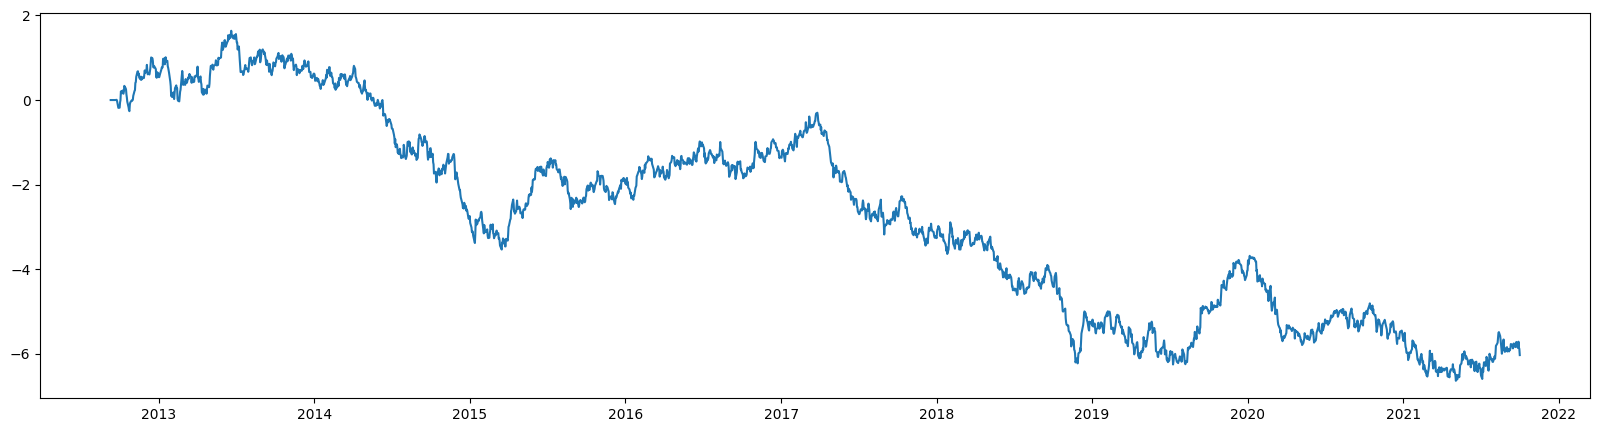

(CVXPY) Jun 14 11:43:48 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:43:52.070674 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6666
           1       0.33      1.00      0.50      3291

    accuracy                           0.33      9957
   macro avg       0.17      0.50      0.25      9957
weighted avg       0.11      0.33      0.16      9957

[[   0 6666]
 [   0 3291]]
[0.53847999 0.58130534 0.59241201 0.59648888 0.5991232  0.54729852
 0.60139684 0.61732333 0.62033792 0.62140837 0.55249692 0.63488637
 0.6416509  0.6468691  0.65434963 0.58198538 0.65715756 0.6722408
 0.67427614 0.68220994 0.59621287 0.71459167 0.74644764 0.75384167
 0.76466556]
100 7 42
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      3049
           1       0.80      0.75      0.77      3049

    accuracy                           0.78      6098
   macro avg       0.78      0.78      0.78      6098
weighted avg       0.78      0.78      0.78      6098

Confusion Matrix
[[2481  568]


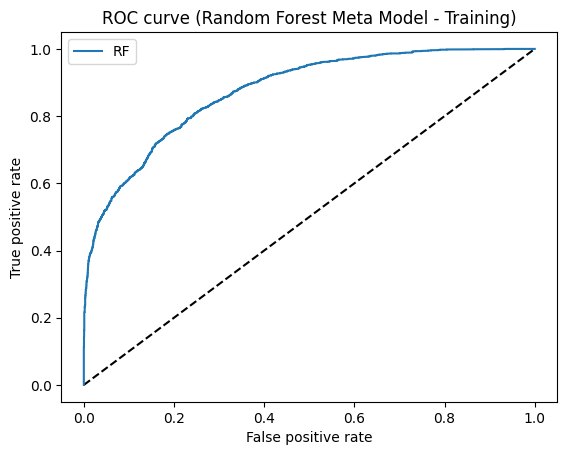

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       533
           1       0.35      0.38      0.37       279

    accuracy                           0.55       812
   macro avg       0.51      0.51      0.51       812
weighted avg       0.56      0.55      0.55       812

Confusion Matrix
[[342 191]
 [174 105]]

Accuracy
0.5504926108374384


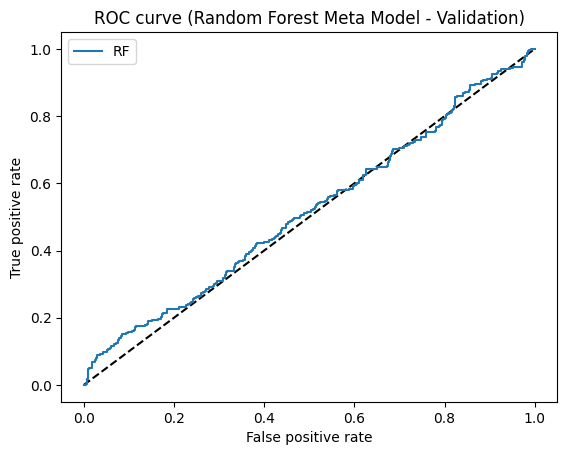

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       533
           1       0.34      1.00      0.51       279

    accuracy                           0.34       812
   macro avg       0.17      0.50      0.26       812
weighted avg       0.12      0.34      0.18       812

Confusion Matrix
[[  0 533]
 [  0 279]]

Accuracy
0.3435960591133005
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      3084
           1       0.35      0.47      0.40      1460

    accuracy                           0.55      4544
   macro avg       0.52      0.53      0.52      4544
weighted avg       0.59      0.55      0.56      4544



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

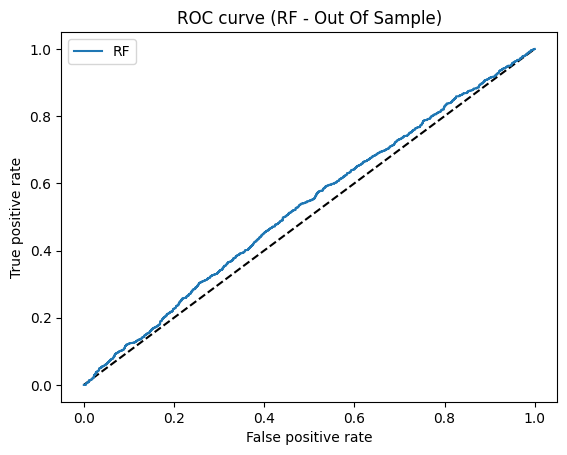

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3084
           1       0.32      1.00      0.49      1460

    accuracy                           0.32      4544
   macro avg       0.16      0.50      0.24      4544
weighted avg       0.10      0.32      0.16      4544

Confusion Matrix
[[   0 3084]
 [   0 1460]]

Accuracy
0.32130281690140844
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

--------------------------------------------
COLUMN: HO
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:44:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
index
2012-09-10 14:00:00    3.2847
2012-09-10 15

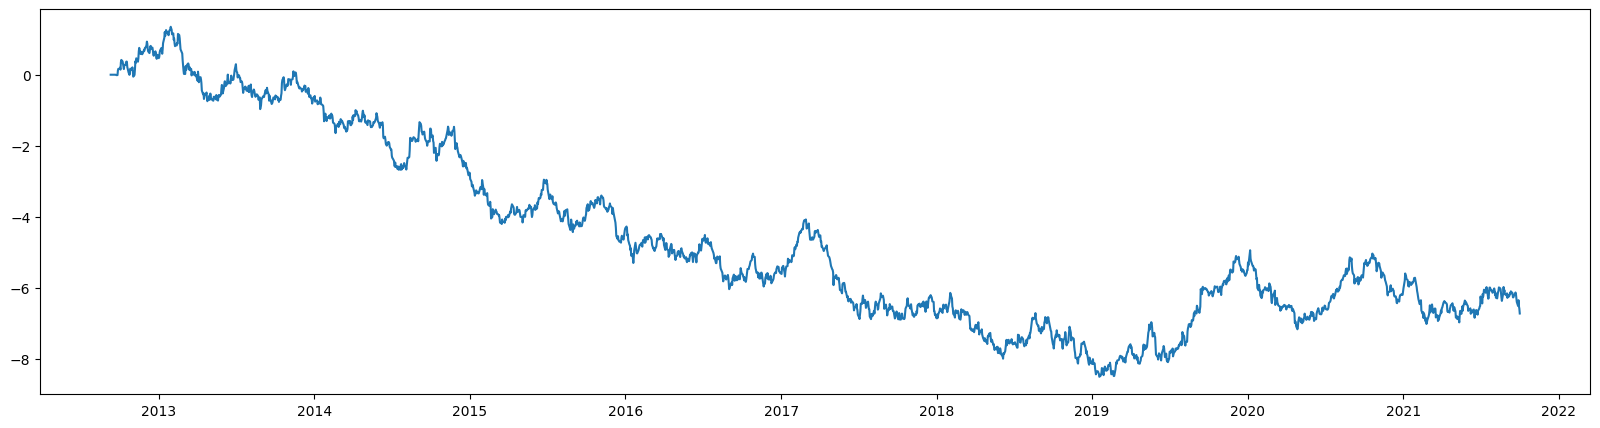

(CVXPY) Jun 14 11:44:28 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:44:31.706436 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6893
           1       0.32      1.00      0.49      3295

    accuracy                           0.32     10188
   macro avg       0.16      0.50      0.24     10188
weighted avg       0.10      0.32      0.16     10188

[[   0 6893]
 [   0 3295]]
[0.53136874 0.59608581 0.61299159 0.6168484  0.61915359 0.55550025
 0.61867437 0.62622348 0.63139643 0.63666367 0.569245   0.64689043
 0.65680763 0.66213087 0.6671072  0.5868451  0.67556031 0.68886029
 0.69210666 0.69847556 0.59748368 0.72783082 0.75296963 0.76364855
 0.76803474]
100 7 42
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2917
           1       0.75      0.78      0.77      2917

    accuracy                           0.76      5834
   macro avg       0.76      0.76      0.76      5834
weighted avg       0.76      0.76      0.76      5834

Confusion Matrix
[[2168  749]

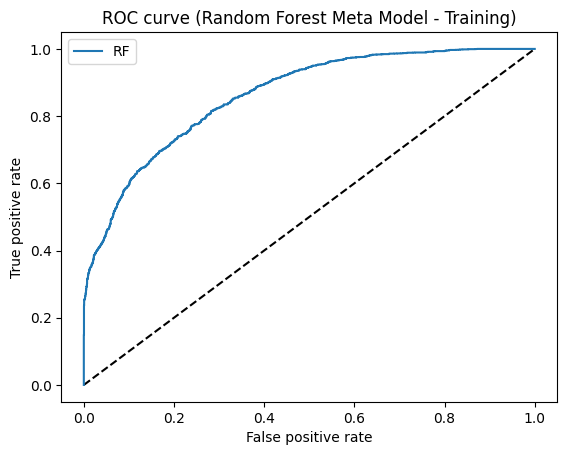

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       524
           1       0.32      0.40      0.36       236

    accuracy                           0.56       760
   macro avg       0.51      0.51      0.51       760
weighted avg       0.58      0.56      0.57       760

Confusion Matrix
[[328 196]
 [142  94]]

Accuracy
0.5552631578947368


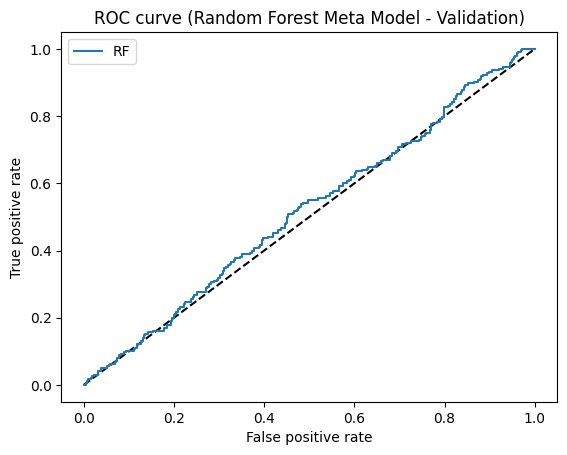

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       524
           1       0.31      1.00      0.47       236

    accuracy                           0.31       760
   macro avg       0.16      0.50      0.24       760
weighted avg       0.10      0.31      0.15       760

Confusion Matrix
[[  0 524]
 [  0 236]]

Accuracy
0.3105263157894737
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3452
           1       0.36      0.44      0.39      1672

    accuracy                           0.56      5124
   macro avg       0.52      0.53      0.52      5124
weighted avg       0.58      0.56      0.57      5124



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

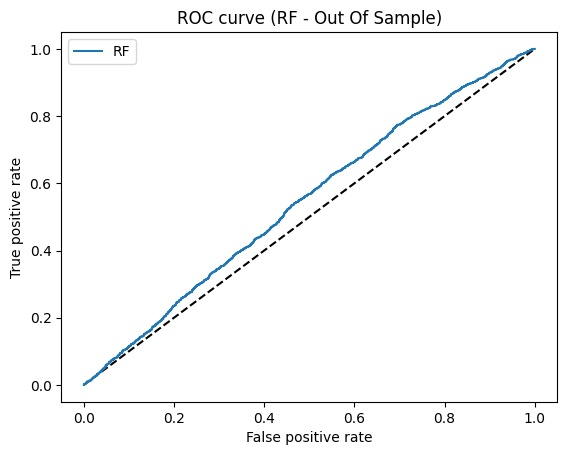

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3452
           1       0.33      1.00      0.49      1672

    accuracy                           0.33      5124
   macro avg       0.16      0.50      0.25      5124
weighted avg       0.11      0.33      0.16      5124

Confusion Matrix
[[   0 3452]
 [   0 1672]]

Accuracy
0.3263075722092115
2023-06-14 11:45:05 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:45:05 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:45:05 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:45:05 {'type': 'csvFuturesSimData'} [Warning]

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [63]:
fuel_prim_accs, fuel_accs, fuel_feat_imps = run_ewmac_meta_labelling_fuels()

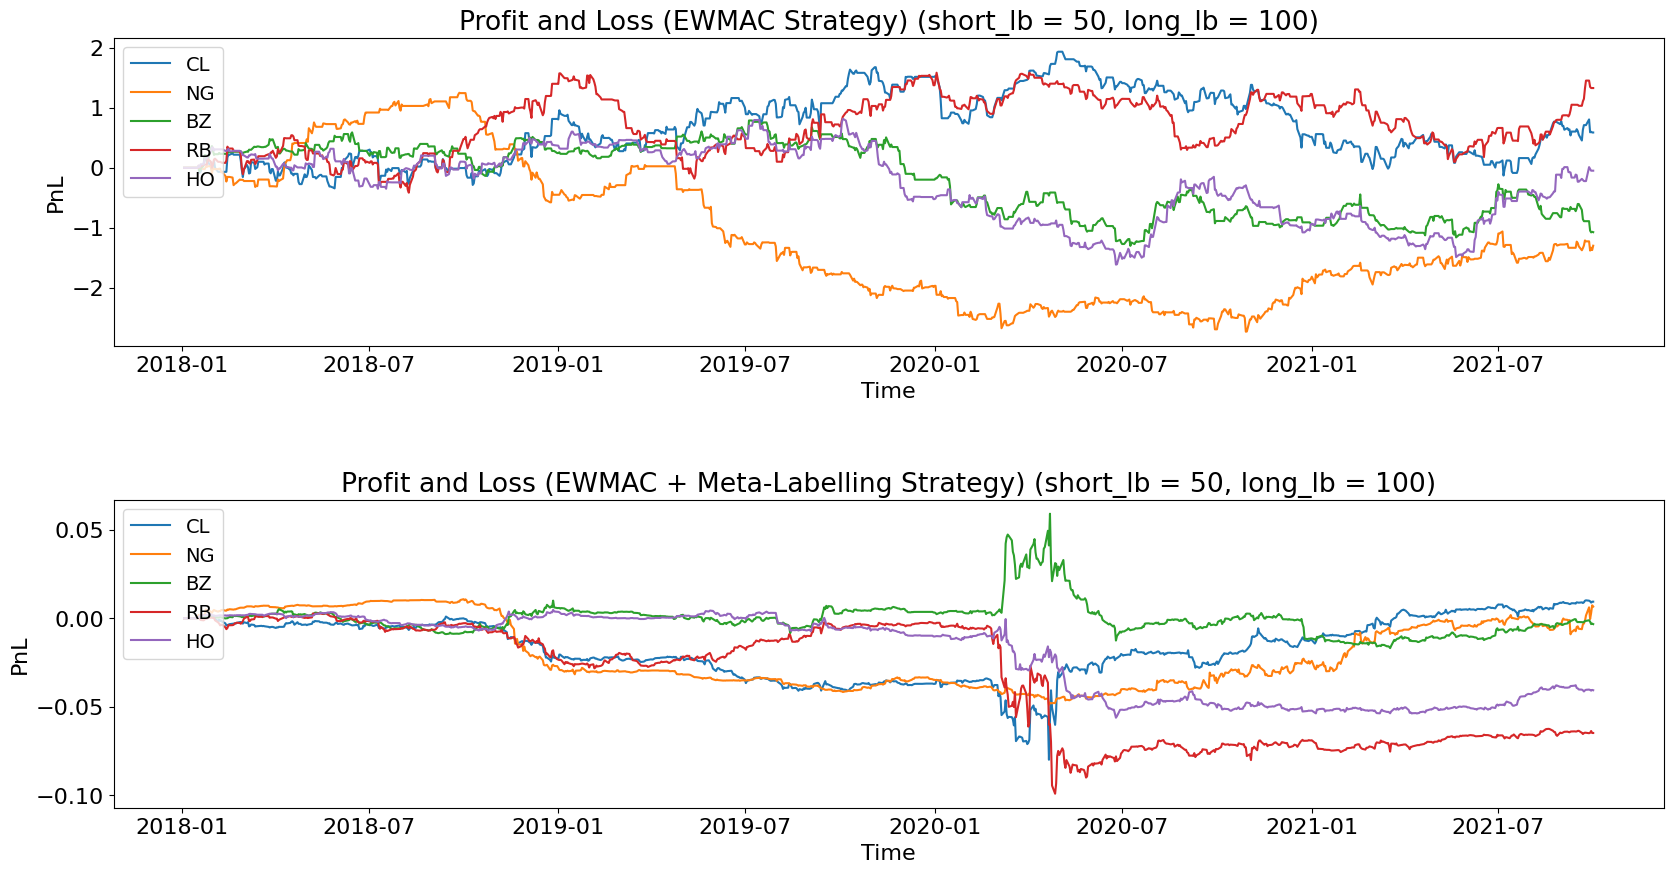

In [82]:
plt.rcParams.update({
    "font.size": 16,
    "legend.fontsize": 14
})

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

for i in range(len(accounts)):
    axs[0].plot(fuel_prim_accs[i].curve(), label=fuel_futures[i])
    axs[0].legend()
    axs[0].title.set_text(f'Profit and Loss (EWMAC Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[0].legend(loc=2)
    axs[0].set_ylabel('PnL')
    axs[0].set_xlabel('Time')
    
    axs[1].plot(fuel_accs[i].curve(), label=fuel_futures[i])
    axs[1].legend()
    axs[1].title.set_text(f'Profit and Loss (EWMAC + Meta-Labelling Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[1].legend(loc=2)
    axs[1].set_ylabel('PnL')
    axs[1].set_xlabel('Time')
    
plt.show()

In [65]:
account_statistics = pd.DataFrame(columns=fuel_futures)

for i in range(len(fuel_accs)):
    
    account_statistics['STATISTICS'] = pd.Series(list(dict(fuel_accs[i].percent.stats()[0]).keys()))

    account_statistics[fuel_futures[i]] = pd.Series([float(x) for x in list(dict(fuel_accs[i].percent.stats()[0]).values())])
    
    print(round(fuel_accs[i].curve().iloc[-1], 6))
            
account_statistics_rounded = account_statistics.round(decimals=6)
account_statistics_rounded
        
account_statistics

0.009429
0.006628
-0.003252
-0.06476
-0.040593


CL        NG        BZ        RB        HO              STATISTICS
0  -0.024140 -0.008260 -0.027420 -0.024690 -0.013010                     min
1   0.022920  0.008662  0.020870  0.032300  0.008652                     max
2   0.000000  0.000000  0.000000  0.000011  0.000000                  median
3   0.000010  0.000007 -0.000003 -0.000066 -0.000042                    mean
4   0.001896  0.001092  0.001944  0.002240  0.001088                     std
5   1.040000 -0.019190 -0.048610 -0.045360 -2.115000                    skew
6   0.002468  0.001735 -0.000851 -0.016950 -0.010630                ann_mean
7   0.030330  0.017470  0.031100  0.035850  0.017400                 ann_std
8   0.081380  0.099300 -0.027370 -0.472900 -0.610600                  sharpe
9   0.094220  0.116000 -0.030300 -0.472100 -0.624100                 sortino
10 -0.019480 -0.029820 -0.028820 -0.037300 -0.024560            avg_drawdown
11  0.965200  0.942700  0.966300  0.977500  0.971400        time_in_drawdown
12  0.030150  0.029110 -0.011210 -0.166100 -0.174400                  calmar
13  0.126700  0.058170 -0.029540 -0.454500 -0.432600  avg_return_to_drawdown
14 -0.000782 -0.000641 -0.000811 -0.001033 -0.000621                avg_loss
15  0.000795  0.000656  0.000832  0.000822  0.000546                avg_gain
16  1.017000  1.023000  1.027000  0.795800  0.878800         gaintolossratio
17  1.025000  1.023000  0.991400  0.863400  0.862100            profitfactor
18  0.502100  0.500000  0.491300  0.520400  0.495200                 hitrate
19  0.159100  0.194100 -0.053510 -0.924300 -1.193000                  t_stat
20  0.873700  0.846100  0.957300  0.355500  0.233000                 p_value

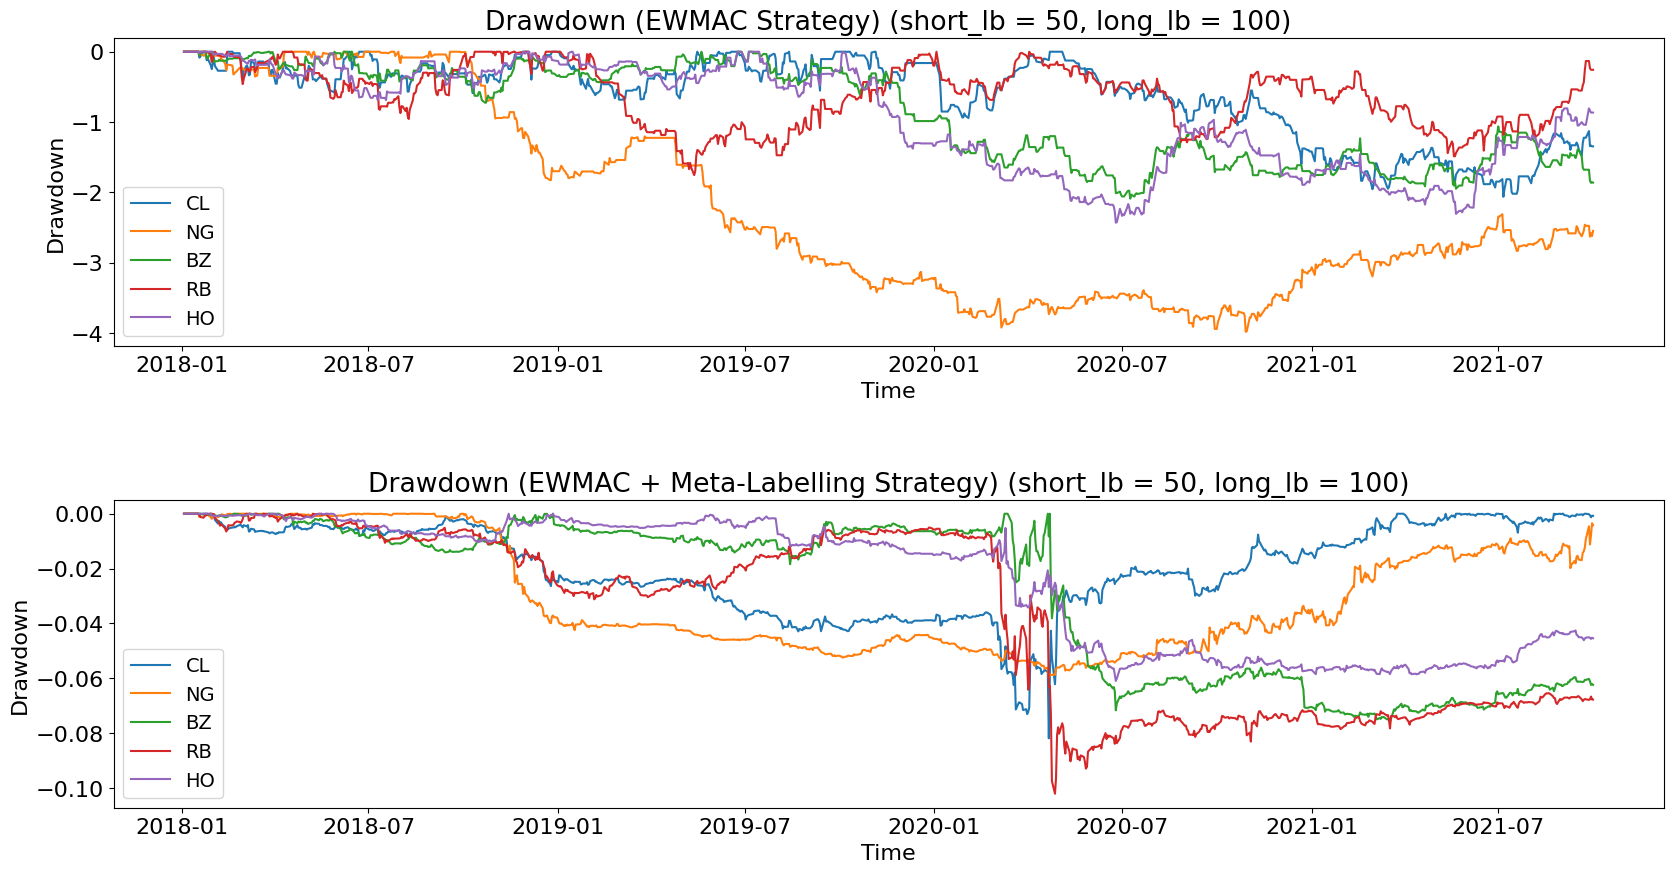

In [83]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

for i in range(len(primary_accounts)):

    axs[0].plot(fuel_prim_accs[i].drawdown(), label=fuel_futures[i])
    axs[0].legend()
    axs[0].title.set_text(f'Drawdown (EWMAC Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[0].legend(loc=3)
    axs[0].set_ylabel('Drawdown')
    axs[0].set_xlabel('Time')
    
    axs[1].plot(fuel_accs[i].drawdown(), label=fuel_futures[i])
    axs[1].legend()
    axs[1].title.set_text(f'Drawdown (EWMAC + Meta-Labelling Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[1].legend(loc=3)
    axs[1].set_ylabel('Drawdown')
    axs[1].set_xlabel('Time')

In [67]:
fuel_prim_accs_statistics = pd.DataFrame(columns=fuel_futures)

for i in range(len(primary_accounts)):
    
    fuel_prim_accs_statistics['STATISTICS'] = pd.Series(list(dict(fuel_prim_accs[i].percent.stats()[0]).keys()))

    fuel_prim_accs_statistics[fuel_futures[i]] = pd.Series([float(x) for x in list(dict(fuel_prim_accs[i].percent.stats()[0]).values())])
    print(round(fuel_prim_accs[i].curve().iloc[-1], 6))
            
fuel_prim_accs_statistics_rounded = fuel_prim_accs_statistics.round(decimals=6)
fuel_prim_accs_statistics_rounded

0.588612
-1.297373
-1.071701
1.329185
-0.047688


CL        NG        BZ        RB        HO              STATISTICS
0  -0.347400 -0.274100 -0.302800 -0.323400 -0.238700                     min
1   0.448600  0.257600  0.307700  0.401200  0.278800                     max
2   0.000000  0.000000  0.000000  0.000000  0.000000                  median
3   0.000602 -0.001327 -0.001096  0.001359 -0.000049                    mean
4   0.071440  0.054580  0.055480  0.067930  0.059120                     std
5   0.026440 -0.518200  0.133800  0.147800  0.516000                    skew
6   0.154100 -0.339600 -0.280500  0.347900 -0.012480                ann_mean
7   1.143000  0.873300  0.887600  1.087000  0.945900                 ann_std
8   0.134800 -0.388800 -0.316000  0.320100 -0.013200                  sharpe
9   0.164400 -0.399600 -0.359600  0.403200 -0.016810                 sortino
10 -0.614200 -2.228000 -0.875800 -0.600900 -0.937600            avg_drawdown
11  0.937600  0.941700  0.967300  0.943800  0.961100        time_in_drawdown
12  0.074700 -0.085310 -0.134300  0.198300 -0.005136                  calmar
13  0.250800 -0.152400 -0.320300  0.579000 -0.013310  avg_return_to_drawdown
14 -0.066010 -0.053050 -0.050860 -0.060260 -0.048500                avg_loss
15  0.066400  0.045280  0.051770  0.064550  0.053010                avg_gain
16  1.006000  0.853500  1.018000  1.071000  1.093000         gaintolossratio
17  1.028000  0.917100  0.930700  1.068000  0.997100            profitfactor
18  0.505500  0.518000  0.477700  0.499200  0.477100                 hitrate
19  0.263500 -0.760000 -0.617700  0.625700 -0.025790                  t_stat
20  0.792200  0.447400  0.536900  0.531700  0.979400                 p_value

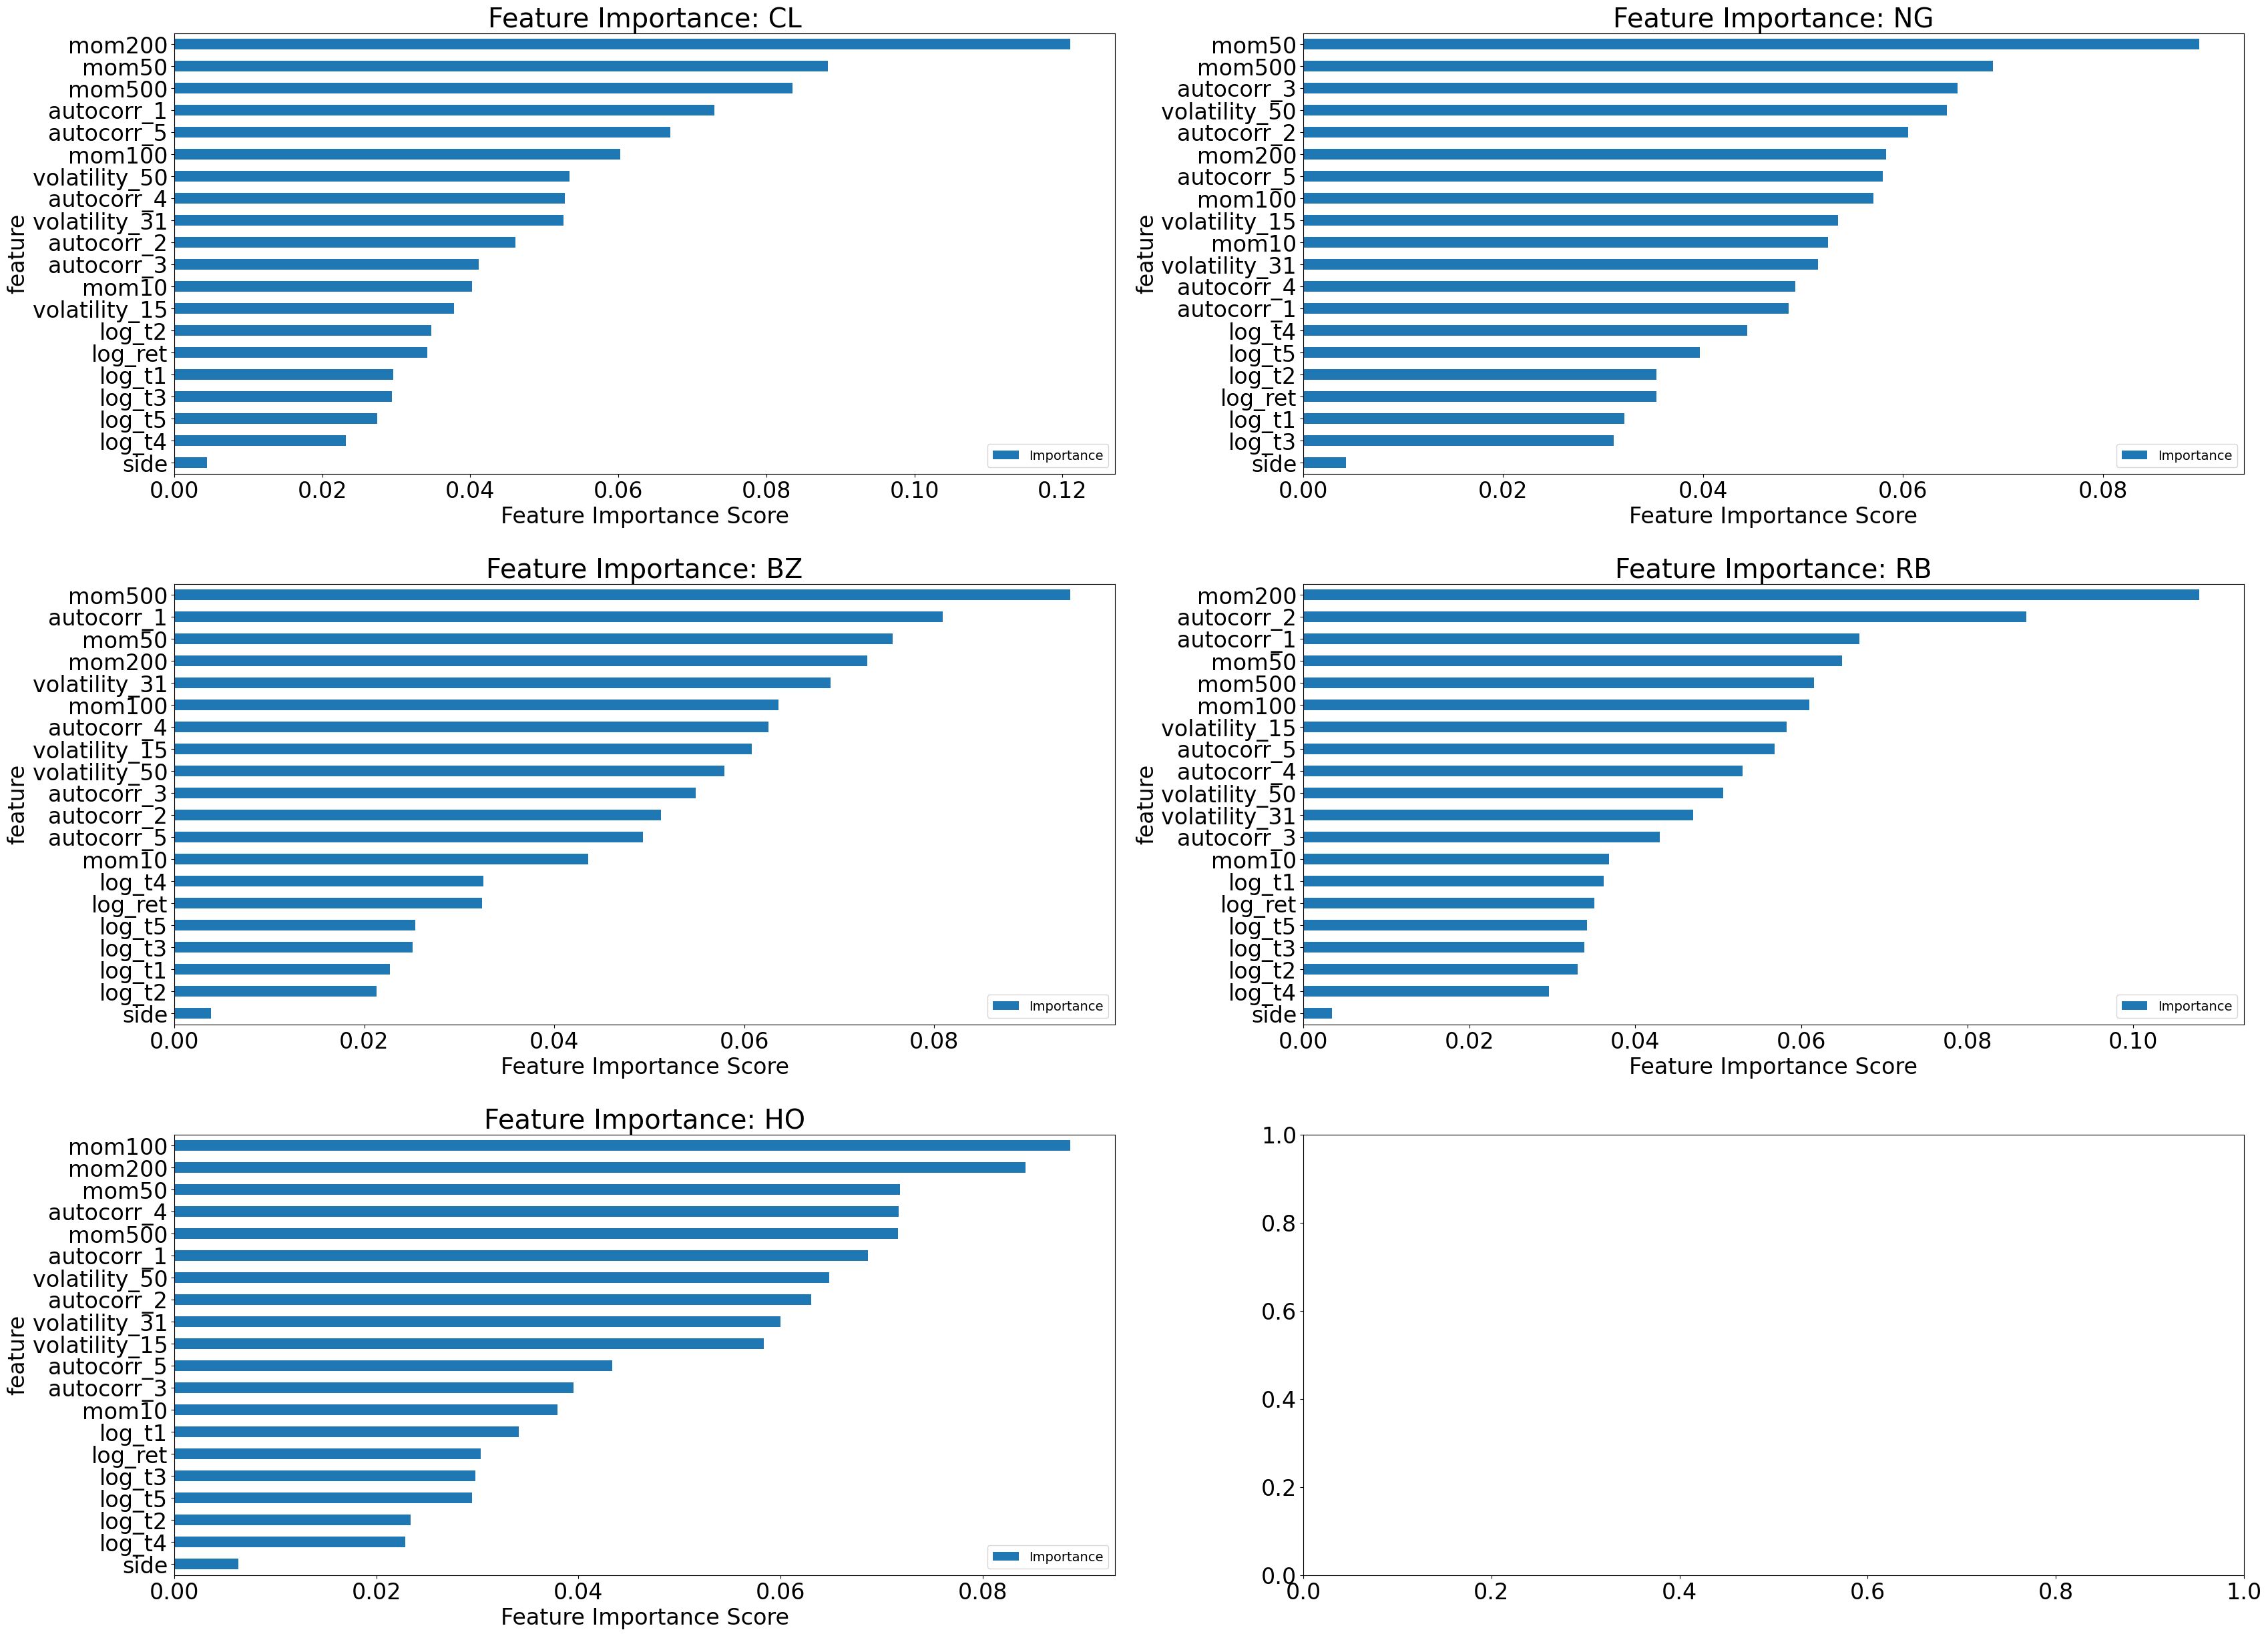

In [81]:
plt.rcParams.update({
    "font.size": 24,
    "legend.fontsize": 14
})
feat_imp_fig, feat_imp_axs = plt.subplots(nrows=3, ncols=2, figsize=(40,30
                                                                ))
plt.subplots_adjust(hspace=0.25)
for i in range(len(fuel_feat_imps)):
    grid_x = i // 2
    grid_y = i % 2
    fuel_feat_imps[i].plot.barh(title=f'Feature Importance: {fuel_futures[i]}', ax=feat_imp_axs[grid_x, grid_y])
    feat_imp_axs[grid_x, grid_y].set_xlabel('Feature Importance Score')
    

#### 3.2 EWMAC+Meta-Labelling on Equity contracts

In [ ]:
def run_ewmac_meta_labelling_equities():
    accounts = []
    feat_imps = []
    primary_accounts = []

    for i in range(len(equity_futures)):
        print("--------------------------------------------")
        print(f"COLUMN: {equity_futures[i]}") 

        csv_path = f"../../pysystemtrade/data/firstrate_futures/{equity_futures[i]}.csv"
        futures_data[equity_futures[i]].to_csv(csv_path, header=["price"])

        # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
        in_csv_file = open(csv_path, "r")
        csv_reader = csv.reader(in_csv_file)

        lines = list(csv_reader)
        lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

        out_csv_file = open(csv_path, "w")
        csv_writer = csv.writer(out_csv_file)
        csv_writer.writerows(lines)

        in_csv_file.close()
        out_csv_file.close()

        # Compute moving averages
        fast_window = 50
        slow_window = 100

        instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))
        data = pd.DataFrame()
        price = instrument_data.get_raw_price(equity_futures[i])
        print(price)
        data[CLOSE] = price
        data[SIDE] = calc_ewmac_forecast(price, fast_window, slow_window)
        data.columns = [CLOSE, 'forecast']

        print(data)

        account = pandl_for_instrument_forecast(forecast=data['forecast'], price=data[CLOSE])
        plt.figure(figsize=(20,5))
        plt.plot(account.curve())
        plt.show()

        data.columns = [CLOSE, SIDE]

        # Save the raw data
        raw_data = data.copy()

        # Drop the NaN values from our data set
        data.dropna(axis=0, how='any', inplace=True)

        # Compute daily volatility
        daily_vol = ml.util.get_daily_vol(close=data[CLOSE], lookback=50)

        # Apply Symmetric CUSUM Filter and get timestamps for events
        # Note: Only the CUSUM filter needs a point estimate for volatility
        cusum_events = ml.filters.cusum_filter(data[CLOSE], threshold=daily_vol['2012-09-30':'2018-01-01'].mean()*0.5)

        # Compute vertical barrier
        vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data[CLOSE], num_days=1)

        pt_sl = [1,2]
        min_ret = 0.005
        triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                                   t_events=cusum_events,
                                                   pt_sl=pt_sl,
                                                   target=daily_vol,
                                                   min_ret=min_ret,
                                                   num_threads=3,
                                                   vertical_barrier_times=vertical_barriers,
                                                   side_prediction=data['side'])

        labels = ml.labeling.get_bins(triple_barrier_events, data[CLOSE])
        labels.side.value_counts()

        primary_forecast = pd.DataFrame(labels[BIN])
        primary_forecast[PRED] = 1
        primary_forecast.columns = [ACTUAL, PRED]

        # Performance Metrics
        actual = primary_forecast[ACTUAL]
        pred = primary_forecast[PRED]
        print(classification_report(y_true=actual, y_pred=pred))

        primary_cm = confusion_matrix(actual, pred)
        print(primary_cm)

    #     disp = ConfusionMatrixDisplay(confusion_matrix=primary_cm,
    #                                display_labels=[0, 1])
    #     disp.plot(cmap='Blues')
    #     plt.savefig(f"../output_figs/primary_forecast_cm_{fuel_futures[i]}")
    #     plt.show()

        # Log Returns
        raw_data['log_ret'] = np.log(raw_data[CLOSE]).diff()

        # Momentum
        raw_data['mom10'] = raw_data[CLOSE].pct_change(periods=10)
        raw_data['mom50'] = raw_data[CLOSE].pct_change(periods=50)
        raw_data['mom100'] = raw_data[CLOSE].pct_change(periods=100)
        raw_data['mom200'] = raw_data[CLOSE].pct_change(periods=200)
        raw_data['mom500'] = raw_data[CLOSE].pct_change(periods=500)

        # Volatility
        raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
        raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
        raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

        # Serial Correlation (Takes about 4 minutes)
        window_autocorr = 50

        raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
        raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
        raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
        raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
        raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

        # Get the various log -t returns
        raw_data['log_t1'] = raw_data['log_ret'].shift(1)
        raw_data['log_t2'] = raw_data['log_ret'].shift(2)
        raw_data['log_t3'] = raw_data['log_ret'].shift(3)
        raw_data['log_t4'] = raw_data['log_ret'].shift(4)
        raw_data['log_t5'] = raw_data['log_ret'].shift(5)

        # Re compute sides
        raw_data['side'] = np.nan

    #     long_signals = raw_data[FAST_EWMA] >= raw_data[SLOW_EWMA]
    #     short_signals = raw_data[FAST_EWMA] < raw_data[SLOW_EWMA]

    #     raw_data.loc[long_signals, 'side'] = 1
    #     raw_data.loc[short_signals, 'side'] = -1

    #     raw_data = raw_data.shift(1)

        raw_data[SIDE] = calc_ewmac_forecast(price, fast_window, slow_window)

        X = raw_data.loc[labels.index, :]

    # Drop unwanted columns
        X.drop([CLOSE],
               axis=1, inplace=True)

        y = labels[BIN]

        # Split data into training, validation and test sets
        X_training_validation = X['2011-09-01':'2018-01-01']
        y_training_validation = y['2011-09-01':'2018-01-01']
        X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation,
                                                                    test_size=0.15, shuffle=False)
        train_df = pd.concat([y_train, X_train], axis=1, join='inner')

        majority = train_df[train_df[BIN] == 0]
        minority = train_df[train_df[BIN] == 1]

        new_minority = resample(minority, 
                           replace=True,  # Sample with replacement
                           n_samples=majority.shape[0],  # To match majority class
                           random_state=42)

        train_df = pd.concat([majority, new_minority])
        train_df = shuffle(train_df, random_state=42)

        train_df[BIN].value_counts()


        y_train = train_df[BIN]
        X_train= train_df.loc[:, train_df.columns != BIN]

        X_train = X_train.fillna(0.0)

        parameters = {'max_depth':[2, 3, 4, 5, 7],
                      'n_estimators':[1, 10, 25, 50, 100],
                      'random_state':[42]}

    #     n_estimator = 25
    #     depth = 5

        n_estimator, depth = perform_grid_search(X_train, y_train)
        c_random_state = 42

        print(n_estimator, depth, c_random_state)

        # Refit a new model with best params, so we can see feature importance
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                                    criterion='entropy', random_state=c_random_state)

        rf.fit(X_train, y_train.values.ravel())

        # Performance Metrics
        y_pred_rf = rf.predict_proba(X_train)[:, 1]
        y_pred = rf.predict(X_train)
        fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
        print(classification_report(y_train, y_pred))

        print("Confusion Matrix")
        cm = confusion_matrix(y_train, y_pred)
        print(cm)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    #                                display_labels=[0, 1])
    #     disp.plot(cmap='Blues')
    #     plt.savefig(f"../output_figs/meta_model_train_cm_{fuel_futures[i]}")
    #     plt.show()


        print('')
        print("Accuracy")
        print(accuracy_score(y_train, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (Random Forest Meta Model - Training)')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        # Meta-label
        # Performance Metrics
        y_pred_rf = rf.predict_proba(X_validate)[:, 1]
        y_pred = rf.predict(X_validate)
        fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
        print(classification_report(y_validate, y_pred))

        print("Confusion Matrix")
        print(confusion_matrix(y_validate, y_pred))

        print('')
        print("Accuracy")
        print(accuracy_score(y_validate, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (Random Forest Meta Model - Validation)')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        # Primary model
        primary_forecast = pd.DataFrame(labels['bin'])
        primary_forecast['pred'] = 1
        primary_forecast.columns = ['actual', 'pred']

        start = primary_forecast.index.get_loc(f'{X_validate.index.min()}')
        end = primary_forecast.index.get_loc(f'{X_validate.index.max()}') + 1

        subset_prim = primary_forecast[start:end]

        # Performance Metrics
        actual = subset_prim['actual']
        pred = subset_prim['pred']
        print(classification_report(y_true=actual, y_pred=pred))

        print("Confusion Matrix")
        print(confusion_matrix(actual, pred))

        print('')
        print("Accuracy")
        print(accuracy_score(actual, pred))

        # Feature Importance

        feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
        feat_imp['feature'] = X.columns
        feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
        feat_imp = feat_imp

        feat_imp.sort_values(by='Importance', inplace=True)
        feat_imp = feat_imp.set_index('feature', drop=True)

        feat_imps.append(feat_imp)
    #     plt.xlabel('Feature Importance Score')
    #     plt.show()

        valid_dates = X_validate.index
        base_rets = labels.loc[valid_dates, 'ret']
        primary_model_rets = get_daily_returns(base_rets)

        meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
        daily_meta_rets = get_daily_returns(meta_returns)

        X_oos = X['2018-01-02':]
        y_oos = y['2018-01-02':]

        y_pred_rf = rf.predict_proba(X_oos)[:, 1]
        y_pred = rf.predict(X_oos)
        fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
        print(classification_report(y_oos, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (RF - Out Of Sample)')
        plt.legend(loc='best')
        plt.show()

        # Primary model
        primary_forecast = pd.DataFrame(labels['bin'])
        primary_forecast['pred'] = 1
        primary_forecast.columns = ['actual', 'pred']

        subset_prim = primary_forecast['2018-01-02':]

        # Performance Metrics
        actual = subset_prim['actual']
        pred = subset_prim['pred']
        print(classification_report(y_true=actual, y_pred=pred))

        print("Confusion Matrix")
        print(confusion_matrix(actual, pred))

        print('')
        print("Accuracy")
        print(accuracy_score(actual, pred))

        test_dates = X_oos.index

        meta_returns = labels.loc[test_dates, 'ret'] * y_pred
        daily_rets_meta = get_daily_returns(meta_returns)

        idx = pd.date_range('2018-01-03 10:00:00', '2021-10-01 10:00:00', freq='H')
        labels = labels.reindex(idx, fill_value=0.0)

        meta_label_forecast = pd.Series(labels['trgt'])
        meta_label_forecast.columns = ['forecast']

        # Convert csv data into data object for pysystemtrade
        instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

            # Get daily prices and calculate the ewmac forecast
        price = instrument_data.get_raw_price(equity_futures[i])
        price_oos = price['2018-01-03 10:00:00':]
        meta_label_forecast.reindex(price_oos.index)

        primary = pd.Series(primary_forecast['actual'])
        primary.reindex(price_oos.index)

        account = pandl_for_instrument_forecast(forecast=meta_label_forecast, price=price_oos)
        accounts.append(account)

        primary_account = pandl_for_instrument_forecast(forecast=primary, price=price_oos)
        primary_accounts.append(primary_account)
    return primary_accounts, accounts, feat_imps

--------------------------------------------
COLUMN: ES
2023-06-14 11:46:00 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:00 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:00 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:00 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:00 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
index
2007-08-20 08:00:00    1243.50
2007-08-20 0

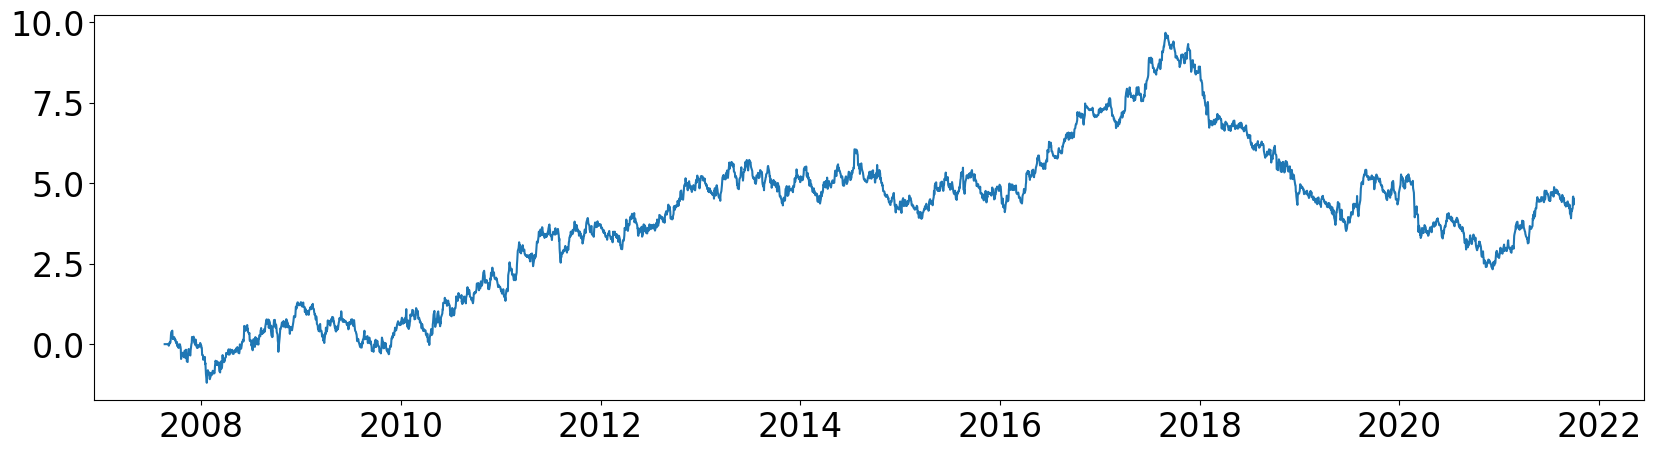

(CVXPY) Jun 14 11:46:02 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:46:06.300966 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11935
           1       0.33      1.00      0.50      6001

    accuracy                           0.33     17936
   macro avg       0.17      0.50      0.25     17936
weighted avg       0.11      0.33      0.17     17936

[[    0 11935]
 [    0  6001]]
[0.52683465 0.61434486 0.62144438 0.62745419 0.62896931 0.5830526
 0.63446858 0.64764247 0.6555579  0.65655842 0.58345433 0.67278886
 0.68569876 0.68647688 0.6892979  0.62314483 0.70145142 0.71597998
 0.72127383 0.72659016 0.637968   0.76800981 0.78535149 0.7993004
 0.80448808]
100 7 42
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2892
           1       0.79      0.73      0.76      2892

    accuracy                           0.77      5784
   macro avg       0.77      0.77      0.77      5784
weighted avg       0.77      0.77      0.77      5784

Confusion Matrix
[[2343  54

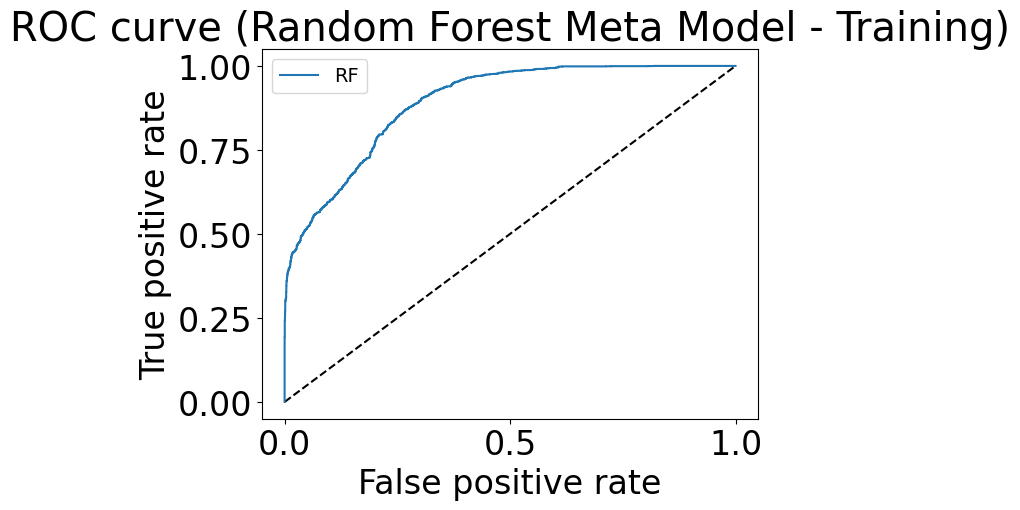

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       543
           1       0.43      0.44      0.44       209

    accuracy                           0.68       752
   macro avg       0.61      0.61      0.61       752
weighted avg       0.68      0.68      0.68       752

Confusion Matrix
[[419 124]
 [116  93]]

Accuracy
0.6808510638297872


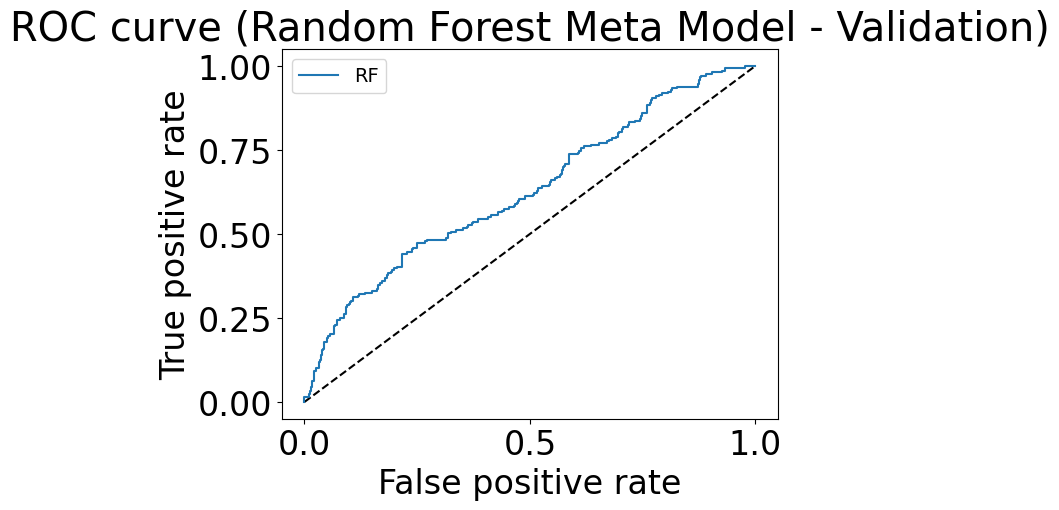

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       543
           1       0.28      1.00      0.43       209

    accuracy                           0.28       752
   macro avg       0.14      0.50      0.22       752
weighted avg       0.08      0.28      0.12       752

Confusion Matrix
[[  0 543]
 [  0 209]]

Accuracy
0.2779255319148936
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      2767
           1       0.40      0.45      0.42      1375

    accuracy                           0.59      4142
   macro avg       0.55      0.56      0.55      4142
weighted avg       0.61      0.59      0.60      4142



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

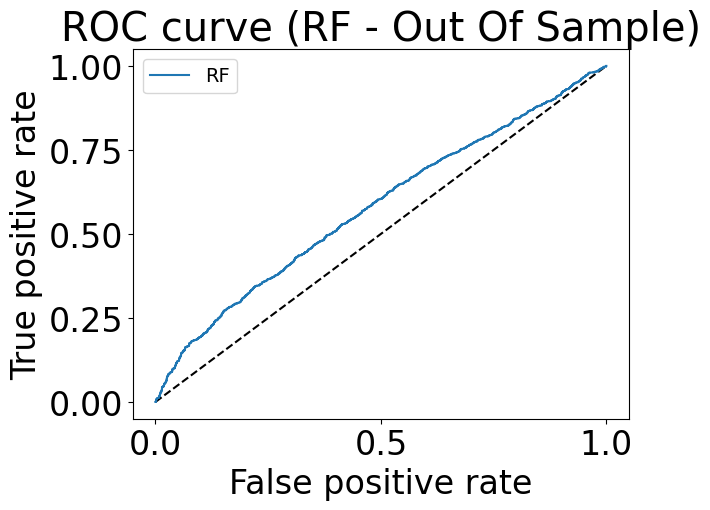

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2767
           1       0.33      1.00      0.50      1375

    accuracy                           0.33      4142
   macro avg       0.17      0.50      0.25      4142
weighted avg       0.11      0.33      0.17      4142

Confusion Matrix
[[   0 2767]
 [   0 1375]]

Accuracy
0.3319652341863834
2023-06-14 11:46:53 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:53 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:53 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:46:53 {'type': 'csvFuturesSimData'} [Warning]

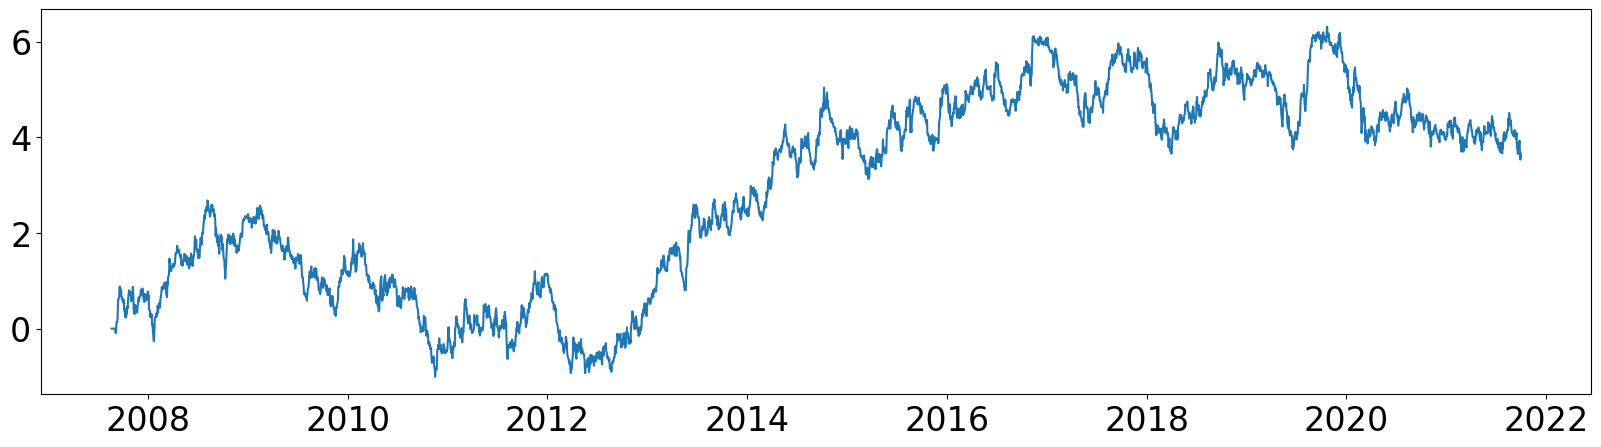

(CVXPY) Jun 14 11:46:55 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:46:59.536811 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11047
           1       0.34      1.00      0.50      5598

    accuracy                           0.34     16645
   macro avg       0.17      0.50      0.25     16645
weighted avg       0.11      0.34      0.17     16645

[[    0 11047]
 [    0  5598]]
[0.56754532 0.62572946 0.62464433 0.62924342 0.62972142 0.57825456
 0.64251801 0.6460544  0.65354469 0.65442173 0.5934715  0.66878201
 0.67902154 0.68542609 0.68783246 0.61557772 0.70407591 0.71966975
 0.7252476  0.7262028  0.64033817 0.767825   0.78050549 0.7949165
 0.79999334]
100 7 42
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2677
           1       0.81      0.80      0.81      2677

    accuracy                           0.81      5354
   macro avg       0.81      0.81      0.81      5354
weighted avg       0.81      0.81      0.81      5354

Confusion Matrix
[[2186  4

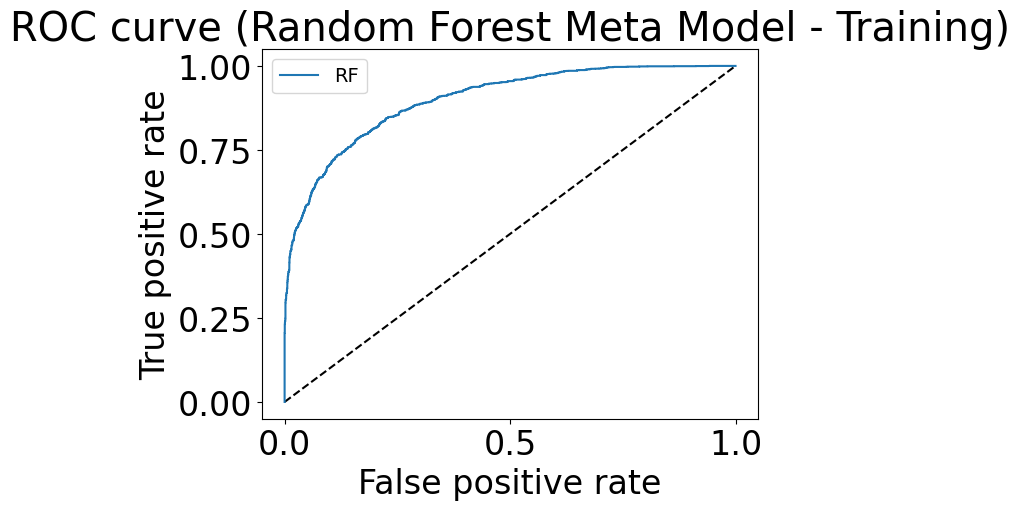

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       518
           1       0.39      0.39      0.39       198

    accuracy                           0.66       716
   macro avg       0.58      0.58      0.58       716
weighted avg       0.66      0.66      0.66       716

Confusion Matrix
[[398 120]
 [121  77]]

Accuracy
0.6634078212290503


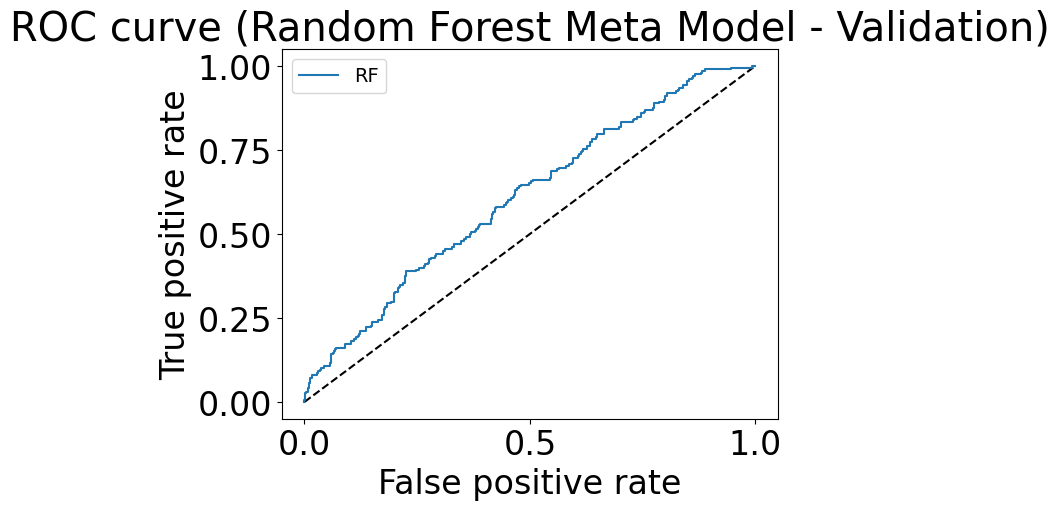

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       518
           1       0.28      1.00      0.43       198

    accuracy                           0.28       716
   macro avg       0.14      0.50      0.22       716
weighted avg       0.08      0.28      0.12       716

Confusion Matrix
[[  0 518]
 [  0 198]]

Accuracy
0.276536312849162
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      3510
           1       0.38      0.47      0.42      1695

    accuracy                           0.58      5205
   macro avg       0.54      0.55      0.54      5205
weighted avg       0.60      0.58      0.59      5205



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

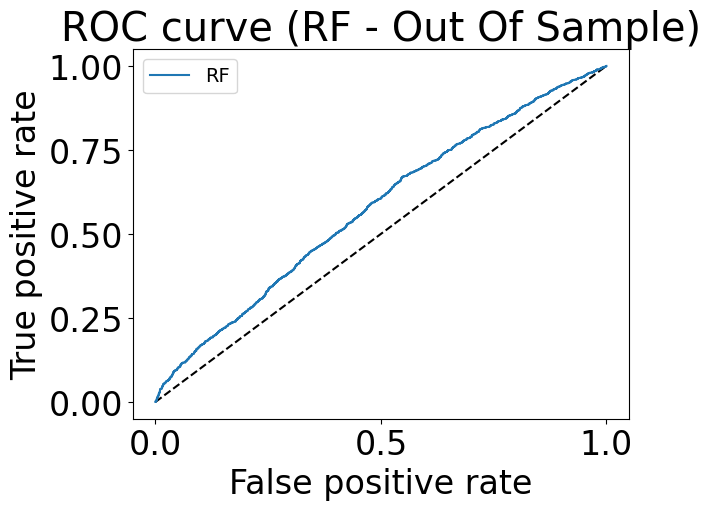

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3510
           1       0.33      1.00      0.49      1695

    accuracy                           0.33      5205
   macro avg       0.16      0.50      0.25      5205
weighted avg       0.11      0.33      0.16      5205

Confusion Matrix
[[   0 3510]
 [   0 1695]]

Accuracy
0.3256484149855908
2023-06-14 11:47:45 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:47:45 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:47:45 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:47:45 {'type': 'csvFuturesSimData'} [Warning]

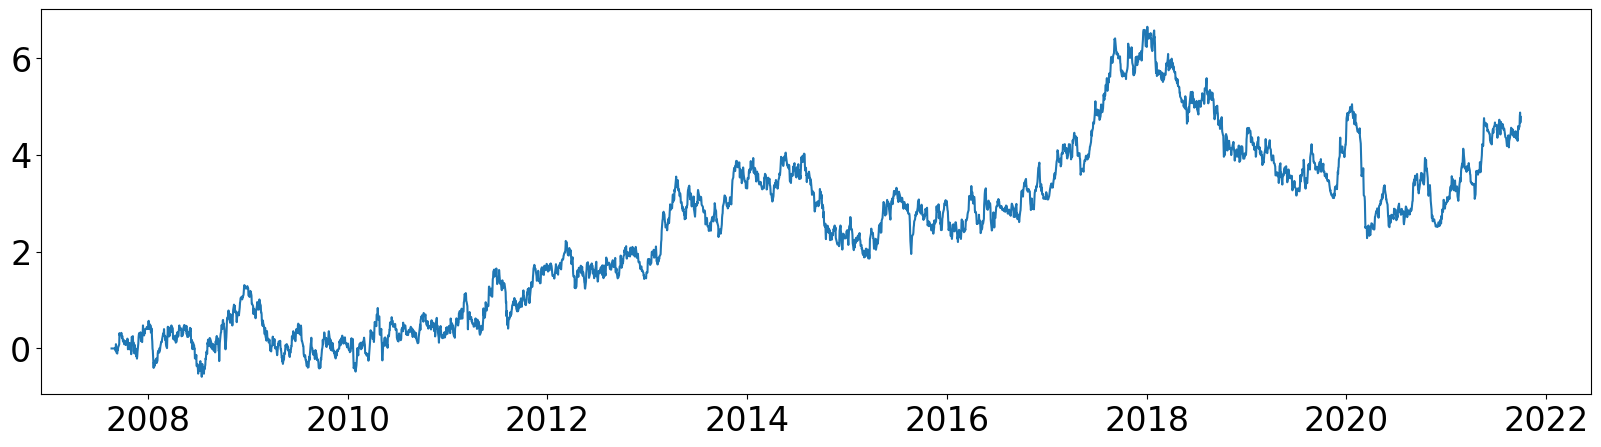

(CVXPY) Jun 14 11:47:48 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:47:51.867787 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10425
           1       0.32      1.00      0.48      4845

    accuracy                           0.32     15270
   macro avg       0.16      0.50      0.24     15270
weighted avg       0.10      0.32      0.15     15270

[[    0 10425]
 [    0  4845]]
[0.53489916 0.60330672 0.61627194 0.61988575 0.6232417  0.57301588
 0.62233272 0.64138587 0.64214651 0.64617899 0.56002699 0.64429349
 0.66454472 0.66893337 0.67431953 0.57629498 0.67597778 0.69543413
 0.69901291 0.70546743 0.6108124  0.7243735  0.74930186 0.75917545
 0.77004513]
100 7 42
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      3560
           1       0.73      0.82      0.77      3560

    accuracy                           0.76      7120
   macro avg       0.76      0.76      0.75      7120
weighted avg       0.76      0.76      0.75      7120

Confusion Matrix
[[2455 1

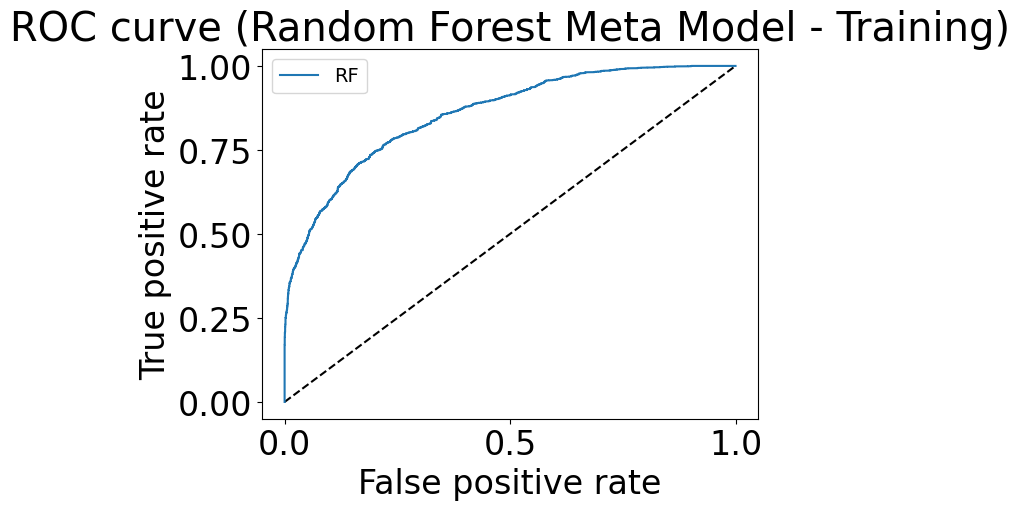

              precision    recall  f1-score   support

           0       0.77      0.49      0.60       640
           1       0.37      0.67      0.47       280

    accuracy                           0.55       920
   macro avg       0.57      0.58      0.54       920
weighted avg       0.65      0.55      0.56       920

Confusion Matrix
[[316 324]
 [ 92 188]]

Accuracy
0.5478260869565217


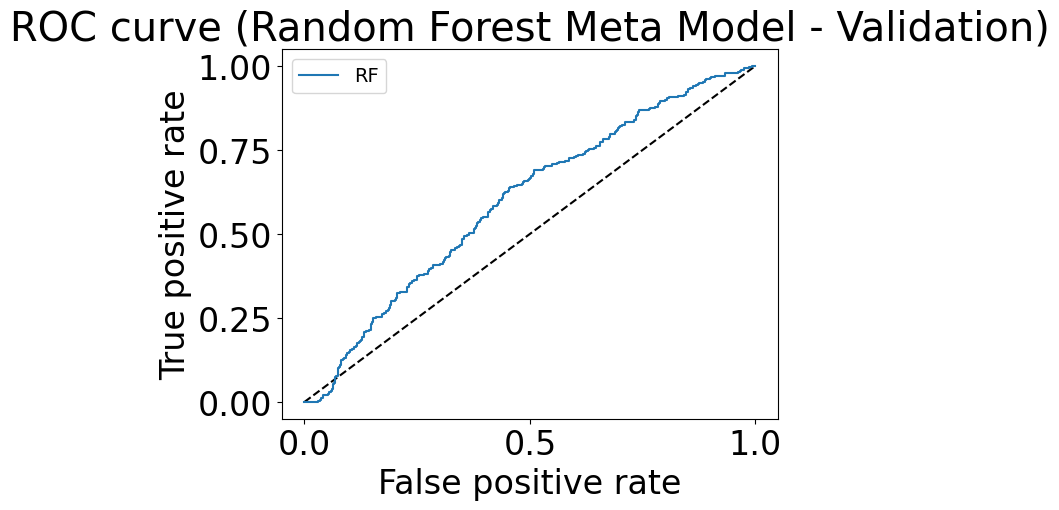

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       640
           1       0.30      1.00      0.47       280

    accuracy                           0.30       920
   macro avg       0.15      0.50      0.23       920
weighted avg       0.09      0.30      0.14       920

Confusion Matrix
[[  0 640]
 [  0 280]]

Accuracy
0.30434782608695654
              precision    recall  f1-score   support

           0       0.72      0.46      0.56      1659
           1       0.36      0.63      0.46       811

    accuracy                           0.52      2470
   macro avg       0.54      0.54      0.51      2470
weighted avg       0.60      0.52      0.53      2470



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

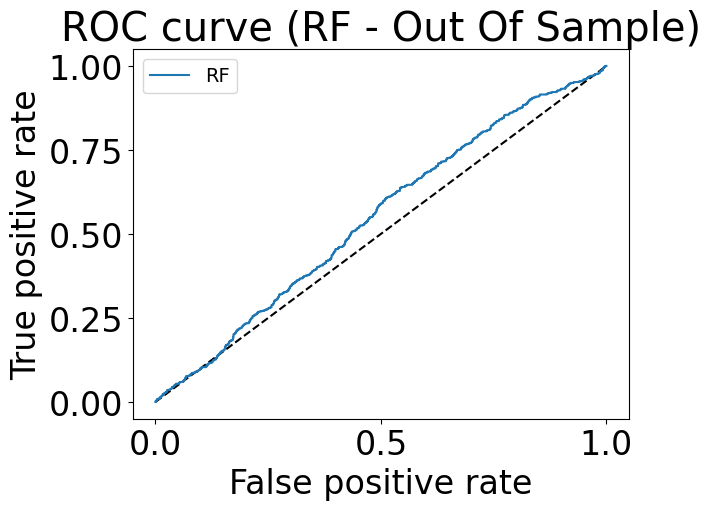

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1659
           1       0.33      1.00      0.49       811

    accuracy                           0.33      2470
   macro avg       0.16      0.50      0.25      2470
weighted avg       0.11      0.33      0.16      2470

Confusion Matrix
[[   0 1659]
 [   0  811]]

Accuracy
0.3283400809716599
2023-06-14 11:48:39 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:48:39 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:48:39 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:48:39 {'type': 'csvFuturesSimData'} [Warning]

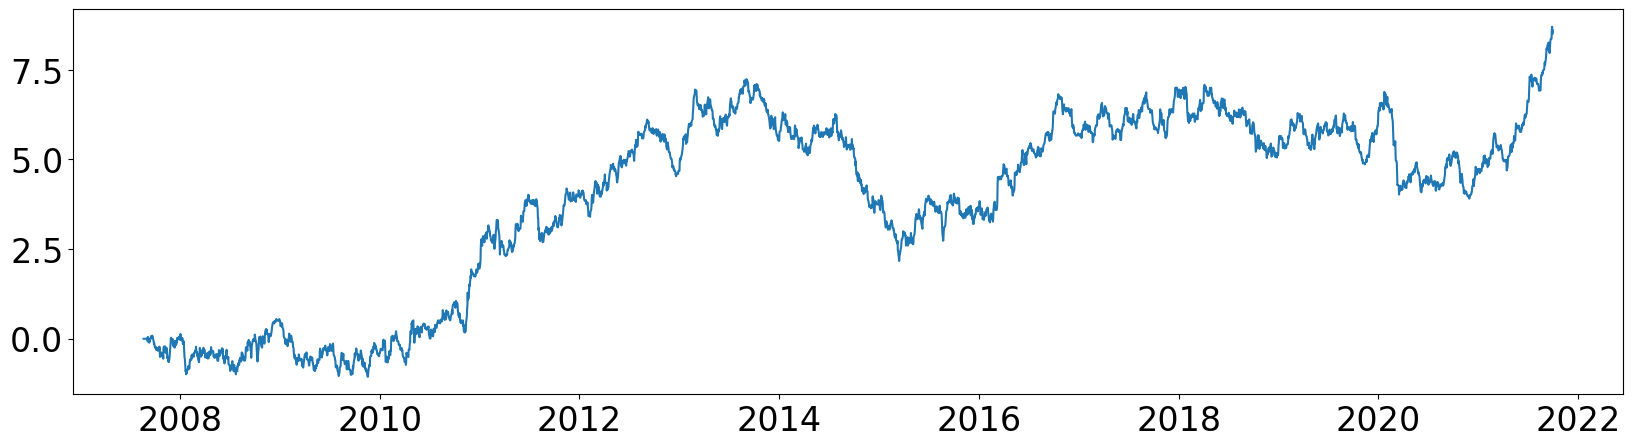

(CVXPY) Jun 14 11:48:42 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:48:45.583213 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8820
           1       0.30      1.00      0.46      3792

    accuracy                           0.30     12612
   macro avg       0.15      0.50      0.23     12612
weighted avg       0.09      0.30      0.14     12612

[[   0 8820]
 [   0 3792]]
[0.53093137 0.59738033 0.61547728 0.61552661 0.61817265 0.54807233
 0.63056894 0.64302052 0.64259496 0.64618334 0.56770642 0.65311293
 0.67023756 0.67849964 0.68206334 0.5860148  0.68980704 0.71216762
 0.71838007 0.71864542 0.5958393  0.7477854  0.78474143 0.7951503
 0.80182719]
100 7 42
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2829
           1       0.80      0.81      0.80      2829

    accuracy                           0.80      5658
   macro avg       0.80      0.80      0.80      5658
weighted avg       0.80      0.80      0.80      5658

Confusion Matrix
[[2244  585]


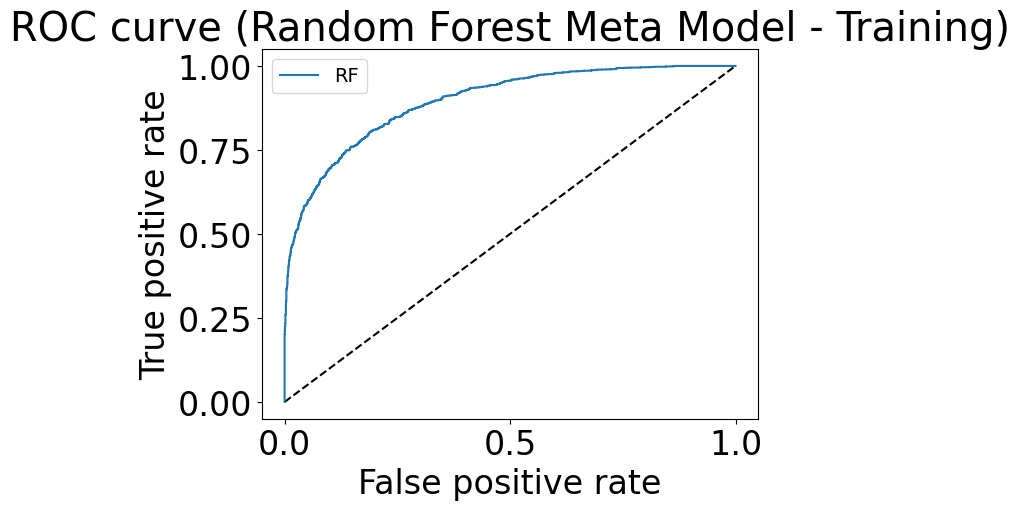

              precision    recall  f1-score   support

           0       0.76      0.64      0.69       521
           1       0.33      0.47      0.39       198

    accuracy                           0.59       719
   macro avg       0.54      0.55      0.54       719
weighted avg       0.64      0.59      0.61       719

Confusion Matrix
[[331 190]
 [105  93]]

Accuracy
0.5897079276773296


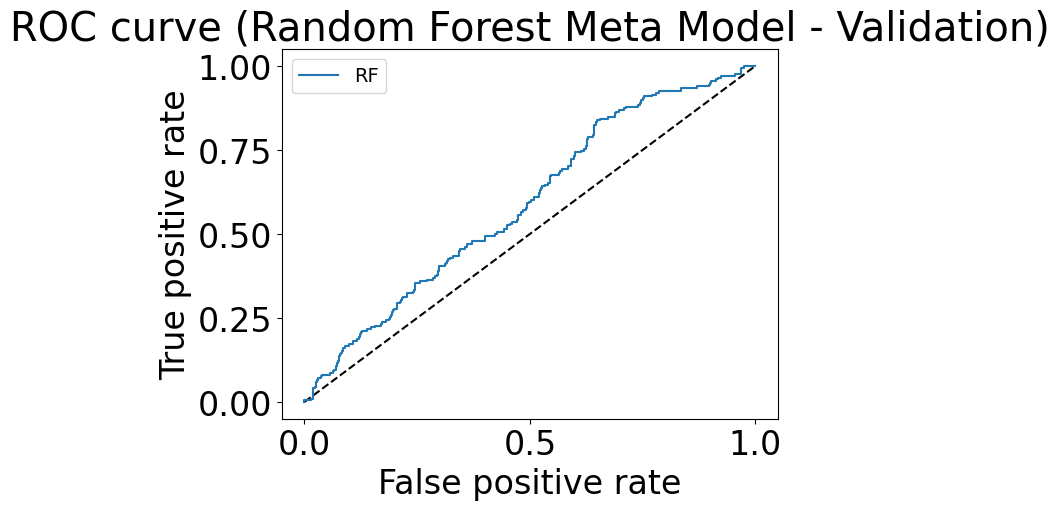

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       521
           1       0.28      1.00      0.43       198

    accuracy                           0.28       719
   macro avg       0.14      0.50      0.22       719
weighted avg       0.08      0.28      0.12       719

Confusion Matrix
[[  0 521]
 [  0 198]]

Accuracy
0.2753824756606398
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      2328
           1       0.31      0.48      0.38       953

    accuracy                           0.54      3281
   macro avg       0.52      0.52      0.50      3281
weighted avg       0.60      0.54      0.56      3281



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

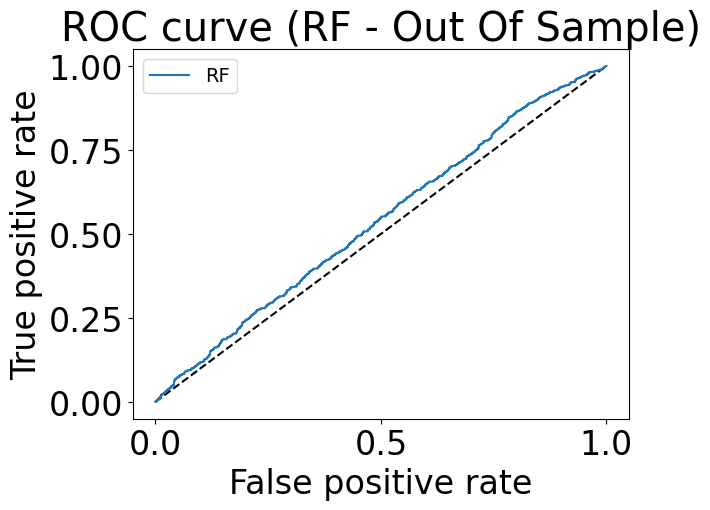

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2328
           1       0.29      1.00      0.45       953

    accuracy                           0.29      3281
   macro avg       0.15      0.50      0.23      3281
weighted avg       0.08      0.29      0.13      3281

Confusion Matrix
[[   0 2328]
 [   0  953]]

Accuracy
0.2904602255409936
2023-06-14 11:49:32 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:49:32 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:49:32 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:49:32 {'type': 'csvFuturesSimData'} [Warning]

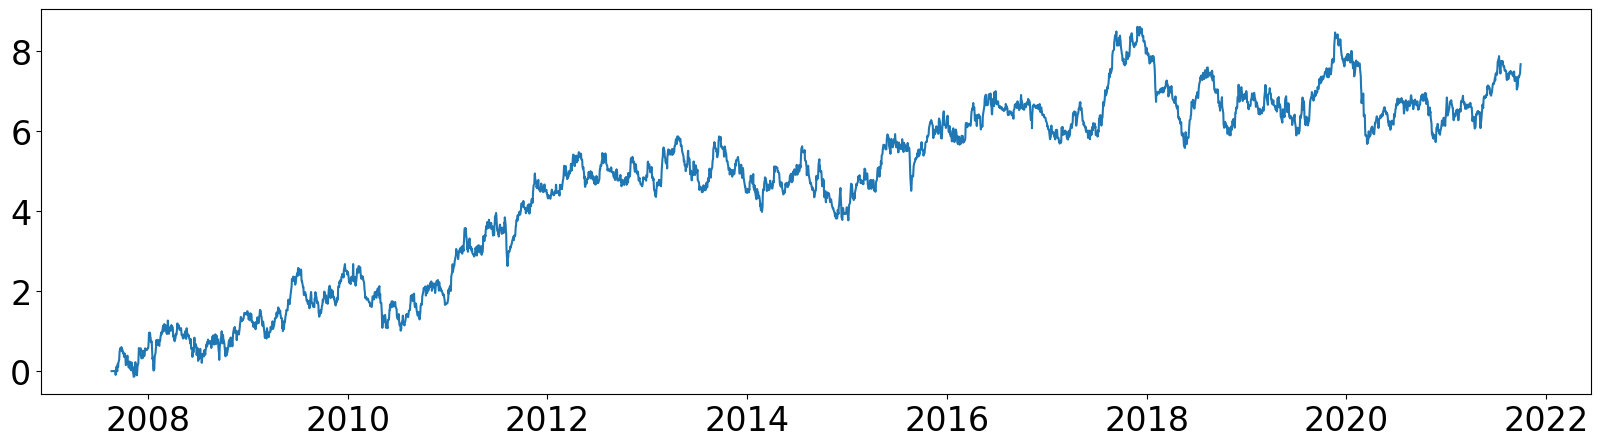

(CVXPY) Jun 14 11:49:35 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-14 11:49:38.896504 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11002
           1       0.31      1.00      0.47      4944

    accuracy                           0.31     15946
   macro avg       0.16      0.50      0.24     15946
weighted avg       0.10      0.31      0.15     15946

[[    0 11002]
 [    0  4944]]
[0.53390727 0.5959166  0.60039876 0.60405026 0.60721154 0.55659848
 0.61945039 0.6252253  0.62882837 0.63191946 0.53680505 0.65034196
 0.65132123 0.65666034 0.66025129 0.56803704 0.67329028 0.68153006
 0.6899773  0.69368649 0.59745676 0.70994678 0.733624   0.75188126
 0.76331539]
100 7 42
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3399
           1       0.83      0.68      0.74      3399

    accuracy                           0.77      6798
   macro avg       0.78      0.77      0.77      6798
weighted avg       0.78      0.77      0.77      6798

Confusion Matrix
[[2919  

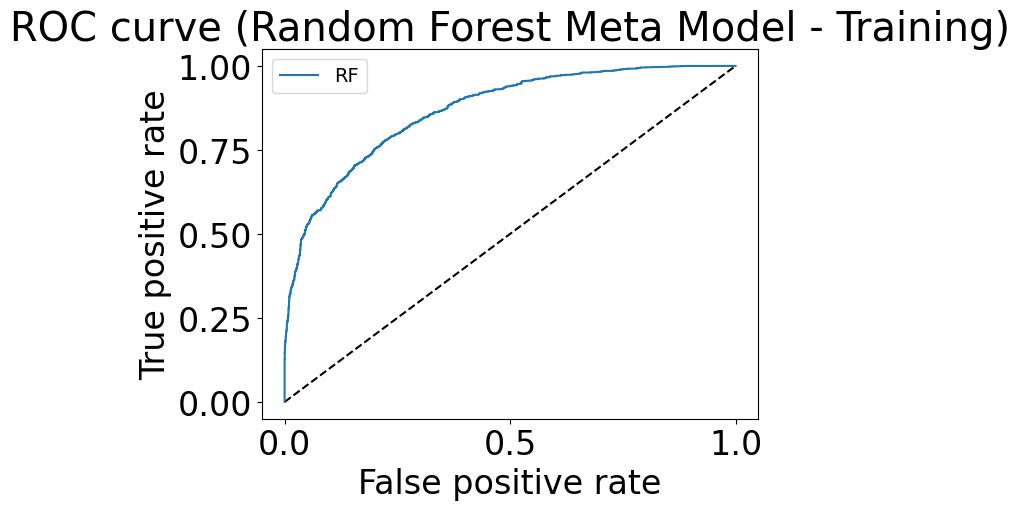

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       608
           1       0.34      0.23      0.27       267

    accuracy                           0.63       875
   macro avg       0.52      0.52      0.51       875
weighted avg       0.59      0.63      0.61       875

Confusion Matrix
[[492 116]
 [206  61]]

Accuracy
0.632


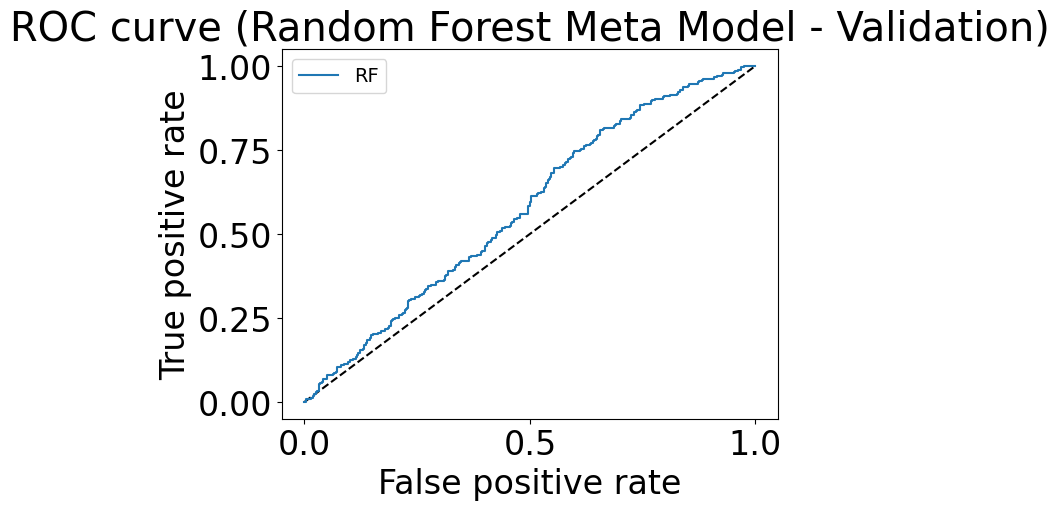

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       608
           1       0.31      1.00      0.47       267

    accuracy                           0.31       875
   macro avg       0.15      0.50      0.23       875
weighted avg       0.09      0.31      0.14       875

Confusion Matrix
[[  0 608]
 [  0 267]]

Accuracy
0.30514285714285716
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2166
           1       0.32      0.31      0.31       969

    accuracy                           0.59      3135
   macro avg       0.51      0.51      0.51      3135
weighted avg       0.58      0.59      0.58      3135



/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

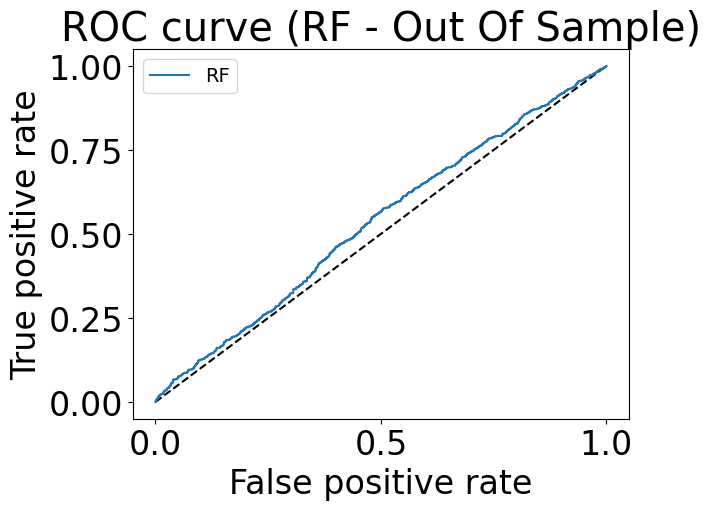

/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2166
           1       0.31      1.00      0.47       969

    accuracy                           0.31      3135
   macro avg       0.15      0.50      0.24      3135
weighted avg       0.10      0.31      0.15      3135

Confusion Matrix
[[   0 2166]
 [   0  969]]

Accuracy
0.3090909090909091
2023-06-14 11:50:28 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:50:28 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:50:28 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-14 11:50:28 {'type': 'csvFuturesSimData'} [Warning]

In [69]:
equities_prim_accs, equities_accs, equities_feat_imps = run_ewmac_meta_labelling_equities()

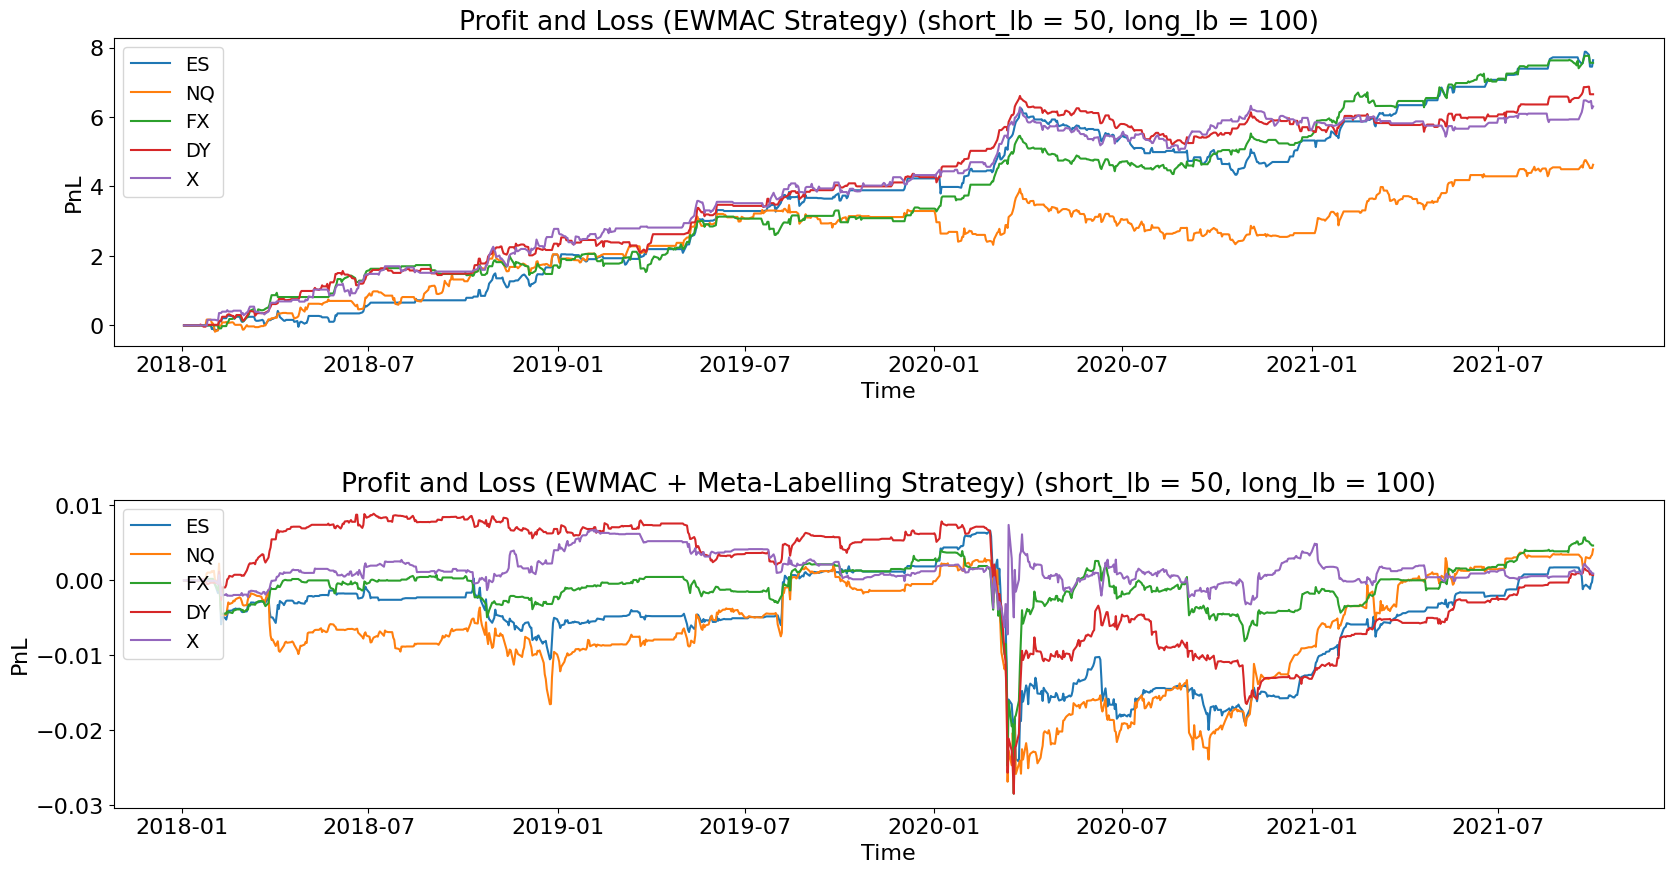

In [75]:
plt.rcParams.update({
    "font.size": 16,
    "legend.fontsize": 14
})



fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

for i in range(len(accounts)):
    axs[0].plot(equities_prim_accs[i].curve(), label=equity_futures[i])
    axs[0].legend()
    axs[0].title.set_text(f'Profit and Loss (EWMAC Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[0].legend(loc=2)
    axs[0].set_ylabel('PnL')
    axs[0].set_xlabel('Time')
    
    axs[1].plot(equities_accs[i].curve(), label=equity_futures[i])
    axs[1].legend()
    axs[1].title.set_text(f'Profit and Loss (EWMAC + Meta-Labelling Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[1].legend(loc=2)
    axs[1].set_ylabel('PnL')
    axs[1].set_xlabel('Time')
    
plt.show()

In [71]:
account_statistics = pd.DataFrame(columns=equity_futures)

for i in range(len(accounts)):
    
    account_statistics['STATISTICS'] = pd.Series(list(dict(accounts[i].percent.stats()[0]).keys()))

    account_statistics[equity_futures[i]] = pd.Series([float(x) for x in list(dict(accounts[i].percent.stats()[0]).values())])
    
    print(round(accounts[i].curve().iloc[-1], 6))
            
account_statistics_rounded = account_statistics.round(decimals=6)
account_statistics_rounded

0.000877
0.004138
0.004645
0.000709
0.000887


ES        NQ        FX        DY         X              STATISTICS
0  -0.009239 -0.011280 -0.013040 -0.010630 -0.004544                     min
1   0.005615  0.005268  0.010160  0.006207  0.014600                     max
2   0.000000  0.000000  0.000000  0.000000  0.000000                  median
3   0.000001  0.000004  0.000005  0.000001  0.000001                    mean
4   0.000764  0.000900  0.000855  0.000709  0.000748                     std
5  -2.212000 -2.335000 -2.001000 -3.218000  7.749000                    skew
6   0.000230  0.001083  0.001216  0.000186  0.000232                ann_mean
7   0.012220  0.014400  0.013690  0.011340  0.011970                 ann_std
8   0.018780  0.075230  0.088830  0.016360  0.019400                  sharpe
9   0.014910  0.069040  0.073320  0.013620  0.023370                 sortino
10 -0.008872 -0.009158 -0.003084 -0.008028 -0.004273            avg_drawdown
11  0.942700  0.973400  0.953000  0.934600  0.944800        time_in_drawdown
12  0.007444  0.036320  0.037480  0.004968  0.016610                  calmar
13  0.025860  0.118300  0.394300  0.023110  0.054320  avg_return_to_drawdown
14 -0.000560 -0.000569 -0.000435 -0.000422 -0.000414                avg_loss
15  0.000462  0.000504  0.000417  0.000366  0.000367                avg_gain
16  0.825200  0.887200  0.960300  0.865600  0.887100         gaintolossratio
17  1.006000  1.020000  1.034000  1.005000  1.007000            profitfactor
18  0.549300  0.534800  0.518600  0.537300  0.531600                 hitrate
19  0.036710  0.147000  0.173600  0.031970  0.037910                  t_stat
20  0.970700  0.883100  0.862200  0.974500  0.969800                 p_value

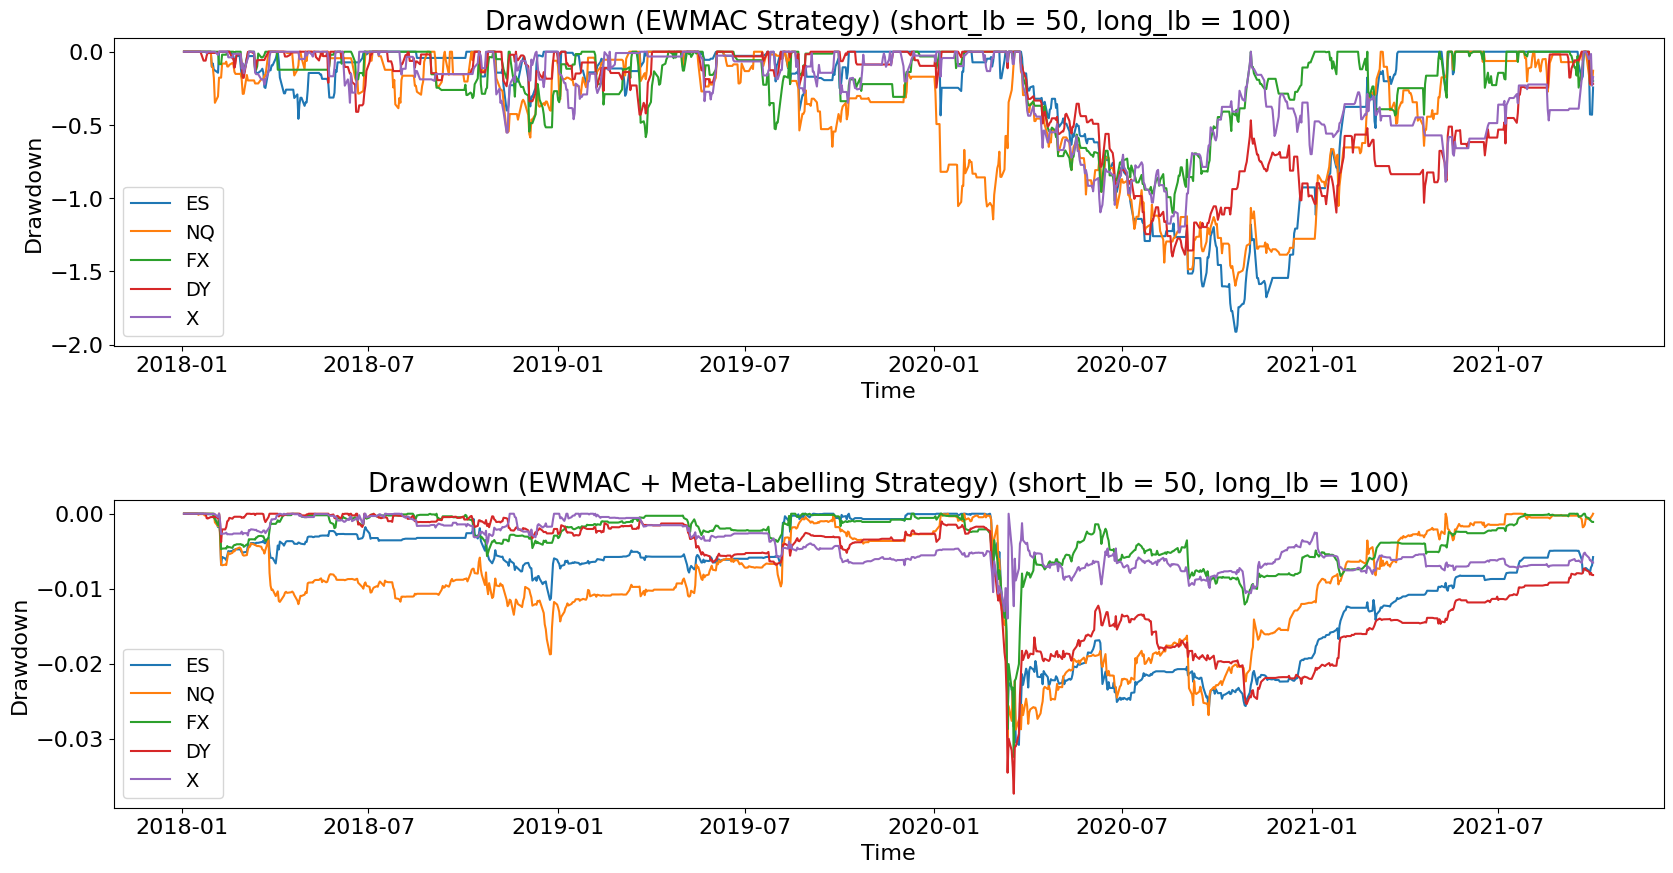

In [84]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

for i in range(len(primary_accounts)):

    axs[0].plot(primary_accounts[i].drawdown(), label=equity_futures[i])
    axs[0].legend()
    axs[0].title.set_text(f'Drawdown (EWMAC Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[0].legend(loc=3)
    axs[0].set_ylabel('Drawdown')
    axs[0].set_xlabel('Time')
    
    axs[1].plot(accounts[i].drawdown(), label=equity_futures[i])
    axs[1].legend()
    axs[1].title.set_text(f'Drawdown (EWMAC + Meta-Labelling Strategy) (short_lb = {str(fast_window)}, long_lb = {str(slow_window)})')
    axs[1].legend(loc=3)
    axs[1].set_ylabel('Drawdown')
    axs[1].set_xlabel('Time')

In [77]:
prim_account_statistics = pd.DataFrame(columns=equity_futures)


for i in range(len(primary_accounts)):
    
    prim_account_statistics['STATISTICS'] = pd.Series(list(dict(primary_accounts[i].percent.stats()[0]).keys()))

    prim_account_statistics[equity_futures[i]] = pd.Series([float(x) for x in list(dict(primary_accounts[i].percent.stats()[0]).values())])
    
    print(round(primary_accounts[i].curve().iloc[-1], 6))
        
prim_account_statistics_rounded = prim_account_statistics.round(decimals=6)
prim_account_statistics_rounded

7.634232
4.624615
7.560053
6.653953
6.303461


ES        NQ       FX        DY         X              STATISTICS
0  -0.434600 -0.361600 -0.28310 -0.298100 -0.218300                     min
1   0.301000  0.314000  0.31360  0.305300  0.346100                     max
2   0.000000  0.000000  0.00000  0.000000  0.000000                  median
3   0.007806  0.004729  0.00773  0.006804  0.006445                    mean
4   0.064060  0.069360  0.06260  0.059170  0.062060                     std
5  -0.124300 -0.253000  0.36450  0.322400  0.613400                    skew
6   1.998000  1.211000  1.97900  1.742000  1.650000                ann_mean
7   1.025000  1.110000  1.00200  0.946800  0.993000                 ann_std
8   1.950000  1.091000  1.97600  1.840000  1.662000                  sharpe
9   1.800000  1.149000  2.25500  1.976000  2.139000                 sortino
10 -0.298000 -0.398100 -0.20540 -0.319200 -0.268200            avg_drawdown
11  0.644200  0.829200  0.69630  0.754600  0.809800        time_in_drawdown
12  1.045000  0.757300  1.79900  1.245000  1.337000                  calmar
13  6.706000  3.041000  9.63400  5.456000  6.151000  avg_return_to_drawdown
14 -0.072360 -0.069890 -0.06408 -0.064290 -0.064990                avg_loss
15  0.078390  0.070390  0.07180  0.068200  0.078660                avg_gain
16  1.083000  1.007000  1.12100  1.061000  1.210000         gaintolossratio
17  1.655000  1.279000  1.59600  1.563000  1.466000            profitfactor
18  0.604400  0.559500  0.58750  0.595600  0.547800                 hitrate
19  3.811000  2.132000  3.86200  3.596000  3.248000                  t_stat
20  0.000147  0.033260  0.00012  0.000340  0.001202                 p_value

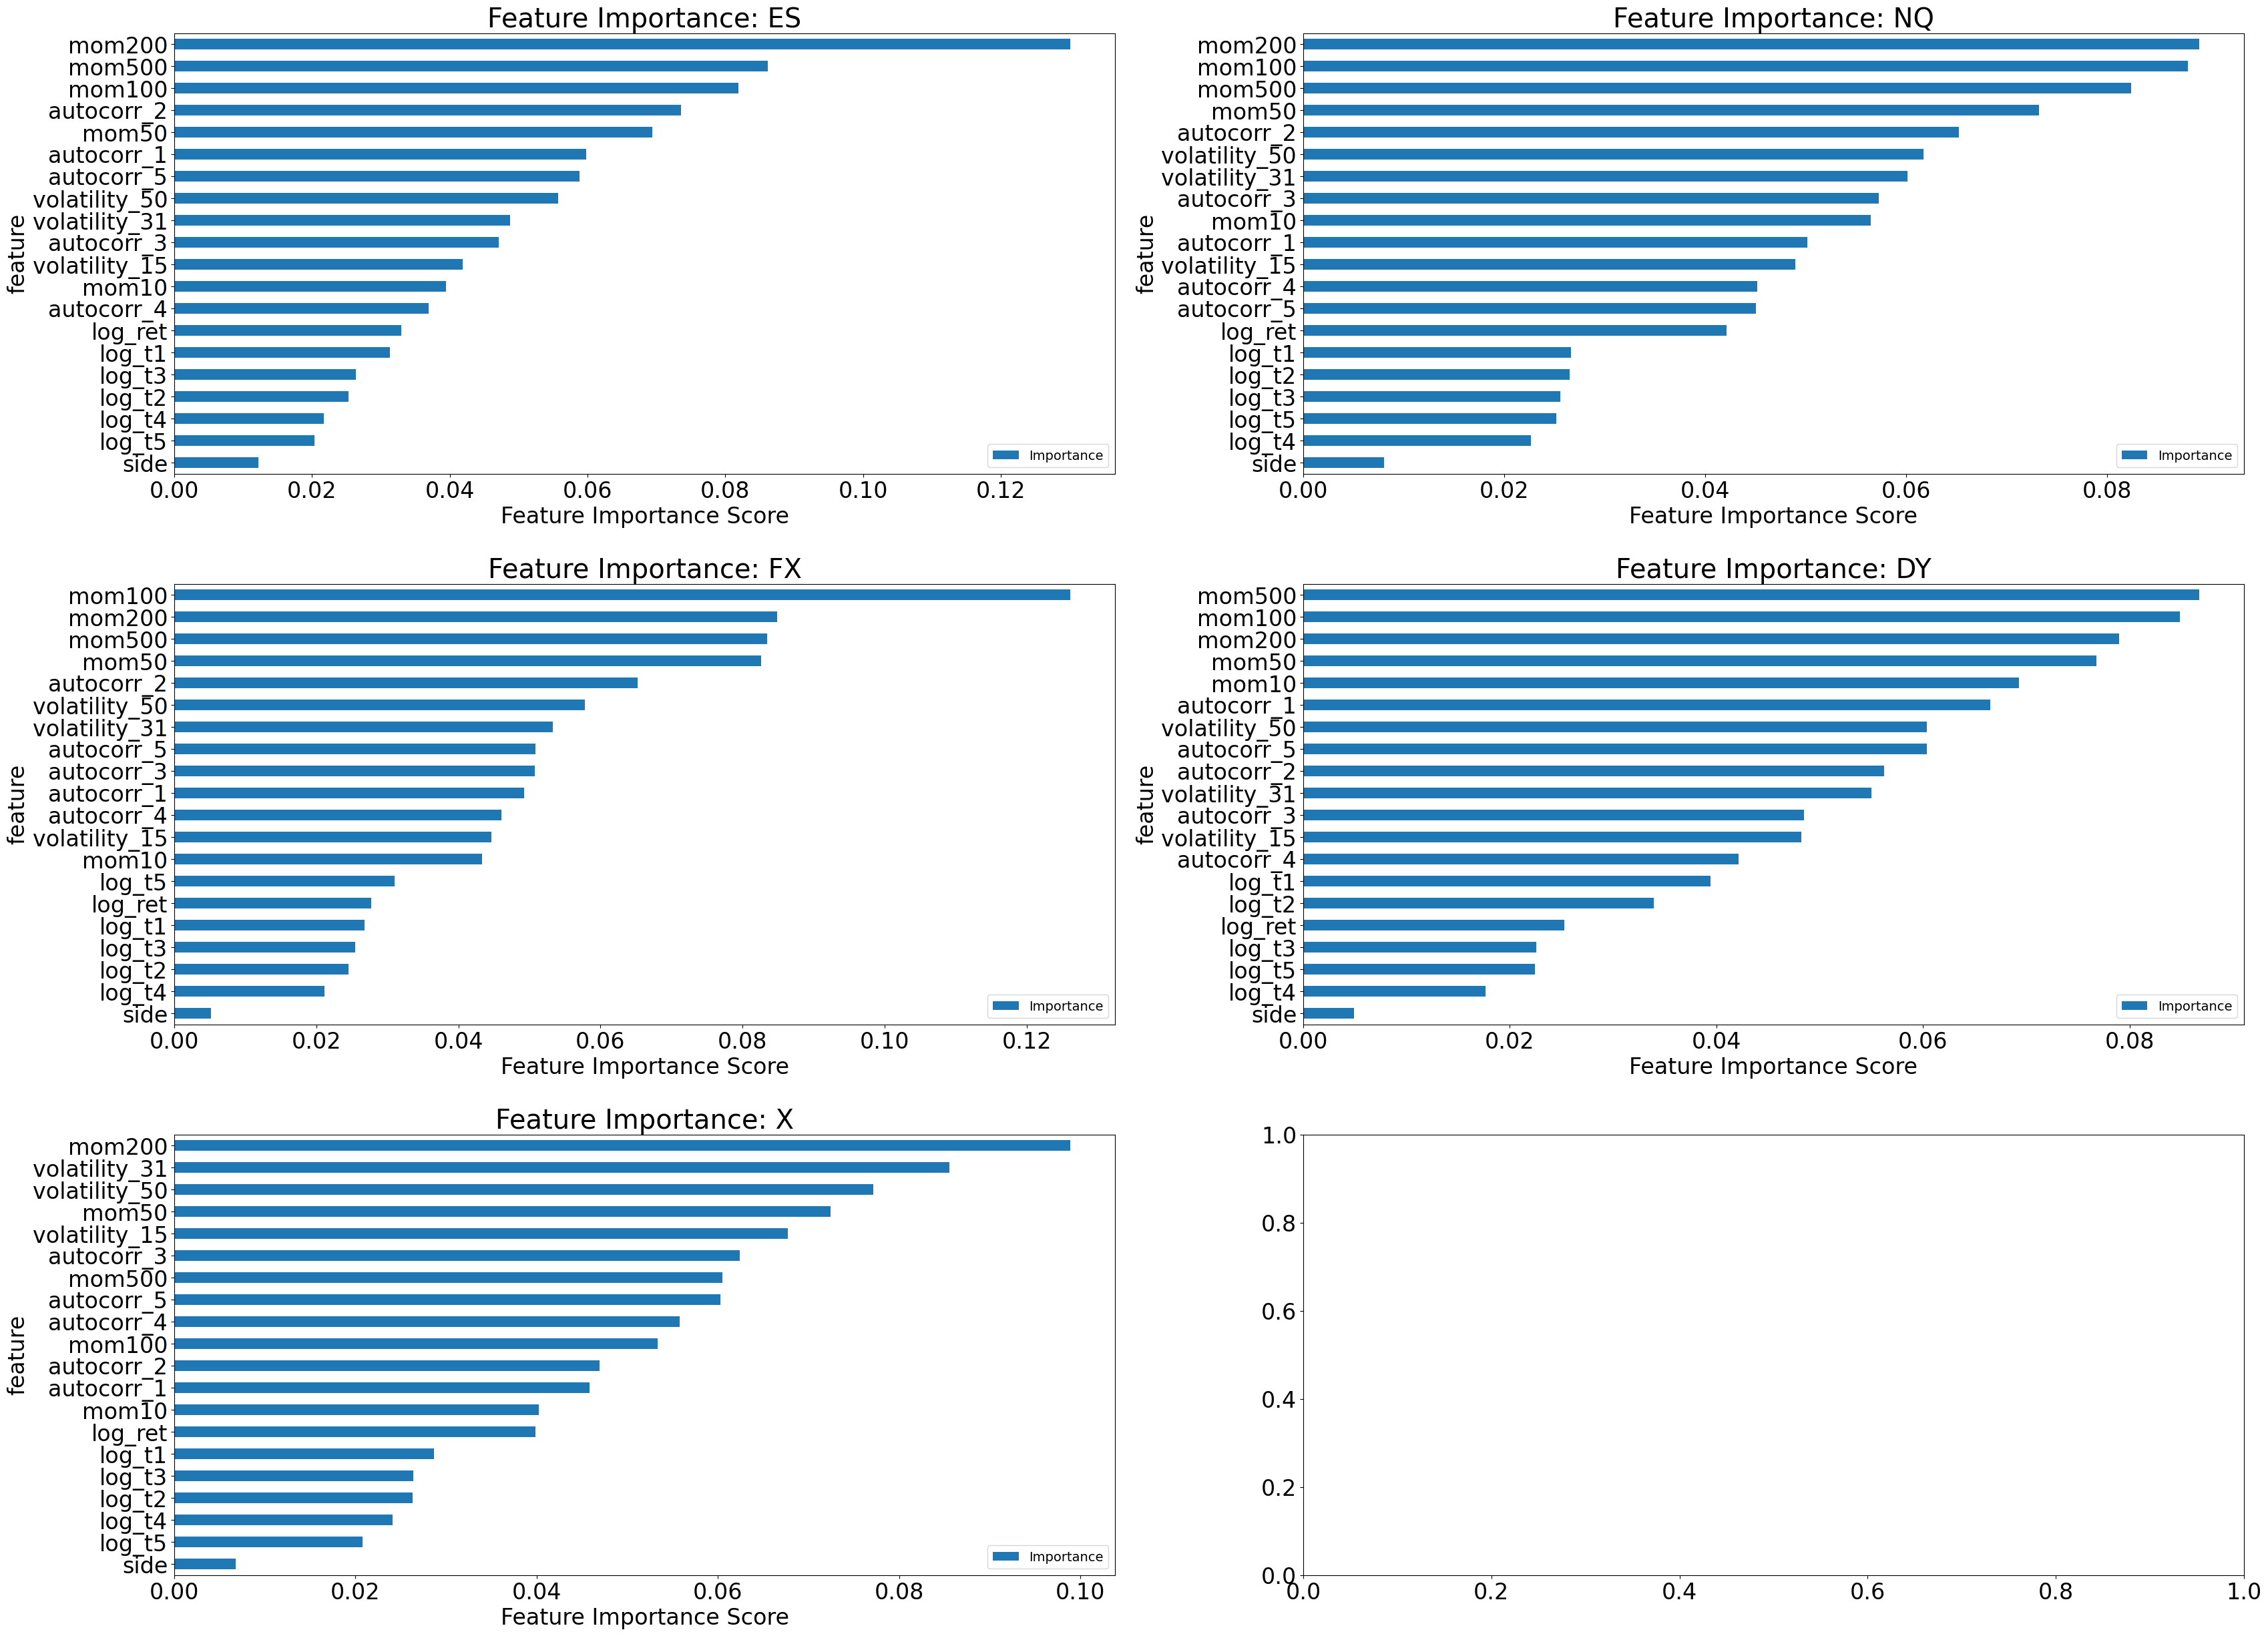

In [78]:
plt.rcParams.update({
    "font.size": 24,
    "legend.fontsize": 14
})
feat_imp_fig, feat_imp_axs = plt.subplots(nrows=3, ncols=2, figsize=(40,30
                                                                ))
plt.subplots_adjust(hspace=0.25)
for i in range(len(equities_feat_imps)):
    grid_x = i // 2
    grid_y = i % 2
    equities_feat_imps[i].plot.barh(title=f'Feature Importance: {equity_futures[i]}', ax=feat_imp_axs[grid_x, grid_y])
    feat_imp_axs[grid_x, grid_y].set_xlabel('Feature Importance Score')